# Dane techniczne sprzętu

Obliczenia zostały wykonane na komputerze o następujących parametrach:

- Procesor: AMD Ryzen $7$ $4700$U ($8$ rdzeni, $8$ wątków),

- Pamięć RAM: $16$ GB $3200$ MHz

# Biblioteki

In [359]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from sympy import Symbol, lambdify
from time import time

In [360]:
sns.set(rc={"figure.dpi": 200, 'savefig.dpi': 200})

# Pomocnicze funkcje

## Wykresy

### Rysowanie wykresu funkcji

In [361]:
def plot_fn(fn, a, b, *, label='', title='Wykres', color='b', step=.1, ax=plt):
    n = int((b - a) / step) + 1
    xs = np.linspace(a, b, n)
    ys = np.vectorize(fn)(xs)
    ax.plot(xs, ys, color, label=label)
    if label: ax.legend(loc='best')
    
    if ax is plt:
        ax.title(title)
        ax.xlabel('x')
        ax.ylabel('y')
    else:
        ax.title.set_text(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    ax.grid()
    
    sns.despine()

### Twprzenie wykresu typu *Heatmap*

In [362]:
def show_heatmap(df, annot=True, norm=None, xlabel='x', ylabel='y', title='', **kwargs):
    ax = plt.figure(figsize=(15, 10))
    s = sns.heatmap(df, cmap="YlGnBu", annot=annot, norm=norm, mask=df.isnull(), **kwargs)
    s.set_xlabel(xlabel, fontsize=16)
    s.set_ylabel(ylabel, fontsize=16)
    plt.title(title, fontsize=20, y=1.025)
    plt.show()

# Zadanie 1

## Badana funkcja

$f(x) = x^n - (1-x)^m$

$n=10$, $m=15$, $x \in [-0.5, 1]$

Stąd, po podstawieniu, otrzymujemy:

$f(x) = x^{10} - (1-x)^{15}$

In [363]:
n = 10
m = 15
a = -.5
b = 1

f = lambda x: x**n - (1 - x)**m

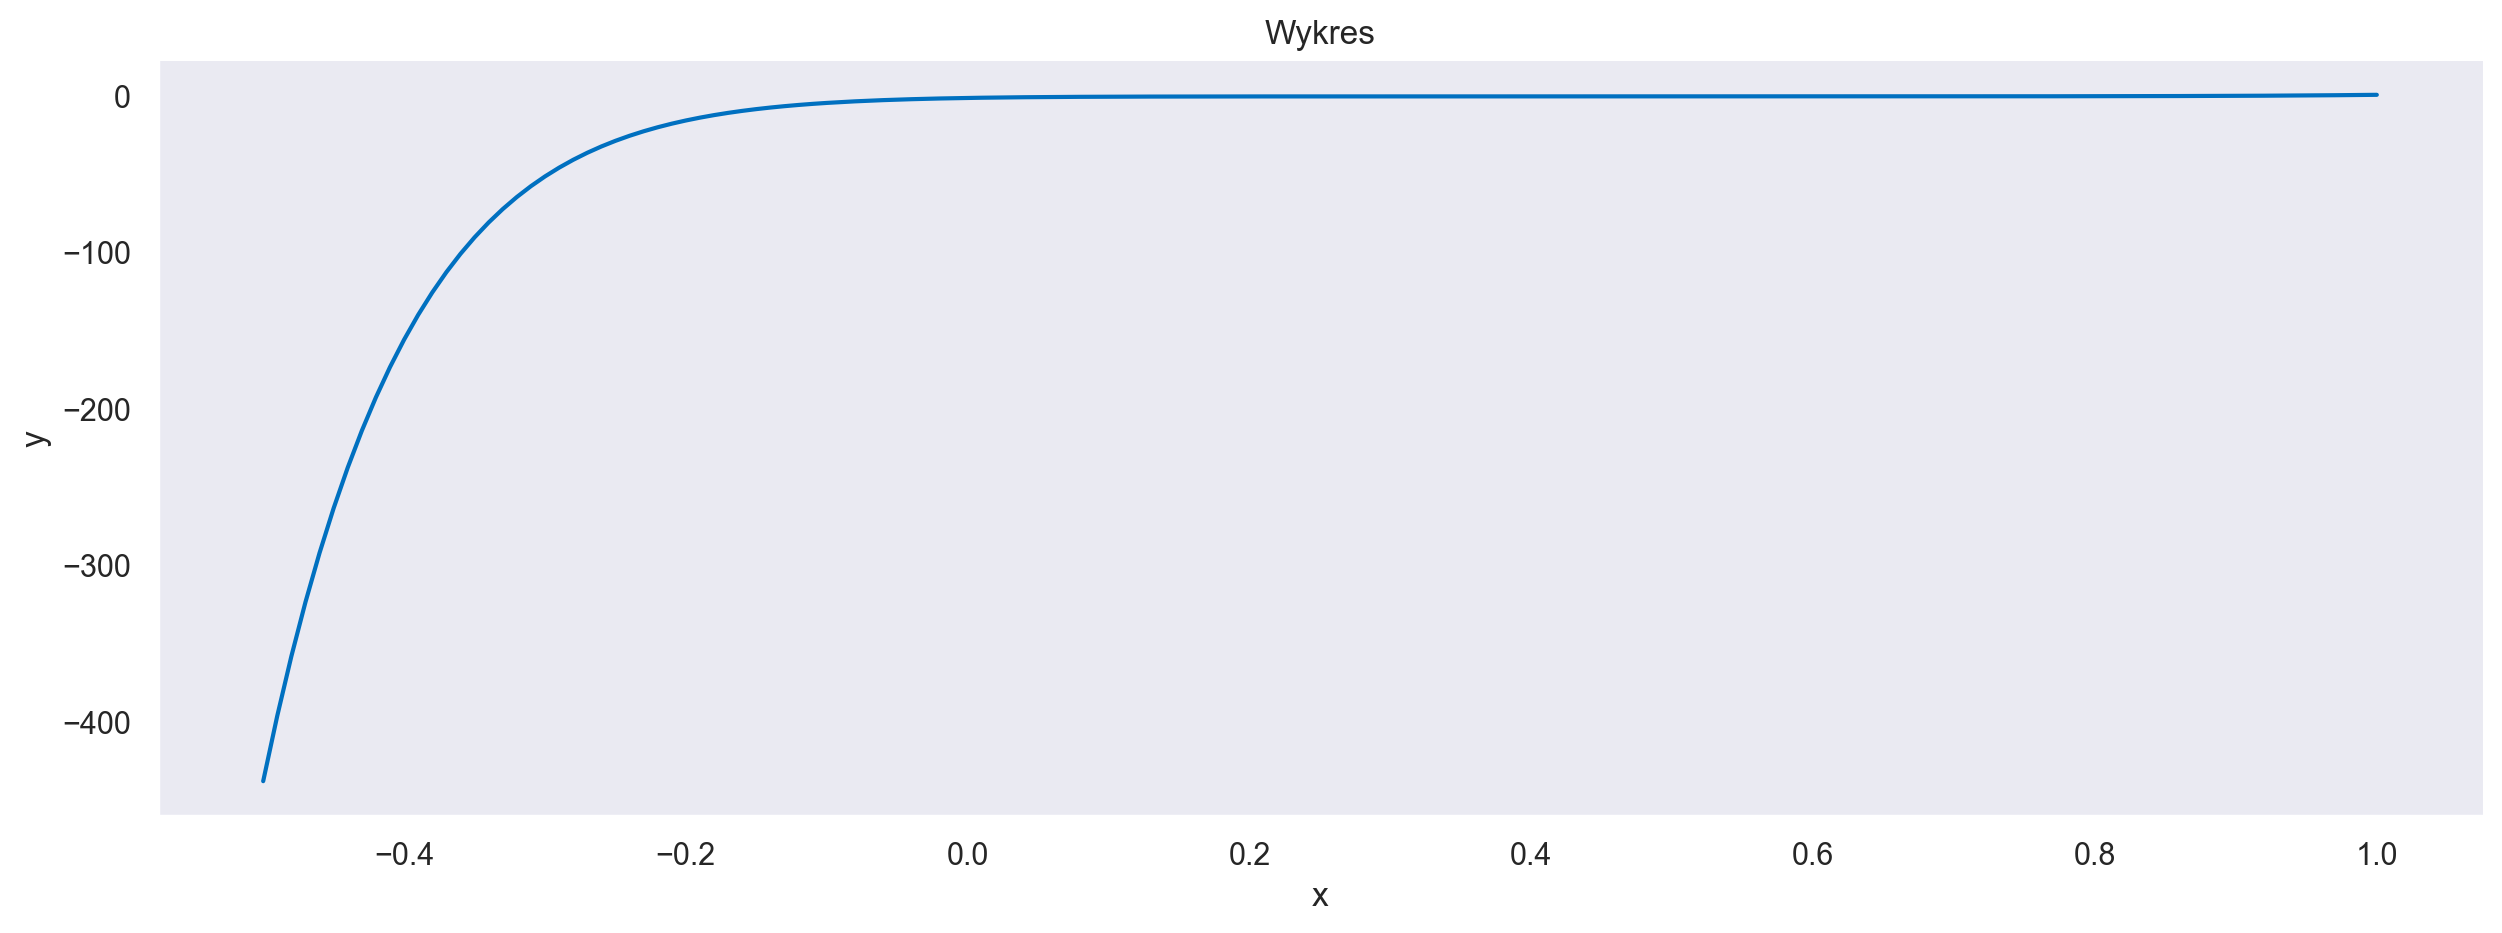

In [364]:
plt.figure(figsize=(15, 5))
plot_fn(f, a, b, step=.01, color='#0070c0')

## Porównywanie liczby iteracji

Do porównania liczby iteracji dla metody Newtona oraz metody siecznych, wykorzystam poniższe kryteria stopu.

### Zastosowane kryteria stopu

#### 1. Kryterium

$|x_{(i+i)} - x_{(i)}| \lt \rho$

In [412]:
stop_criterion_init1 = lambda 𝜌: lambda _, x_prev, x_curr: abs(x_curr - x_prev) < 𝜌

#### 2. Kryterium

$|f(x_i)| \lt \rho$

In [413]:
stop_criterion_init2 = lambda 𝜌: lambda f, _, x_curr: abs(f(x_curr)) < 𝜌

# Zastosowane metody wyznaczania pierwiastków równania

## Metoda Newtona-Raphsona

Korzystamy ze wzoru iteracyjnego:

$\phi(x) = x - \frac{f(x)}{f'(x)}$

Potrzebujemy 1. pochodnej funkcji. Możemy ją wyliczyć analitycznie lub skorzystać z biblioteki `sympy`. Po obliczeniu pochodnej w sposób analityczny, otrzymujemy:

$f(x) = n \cdot x^{(n - 1)} + m \cdot (1-x)^{(m - 1)}$

Ja zdecydowałem się jednak na wyznaczenie pochodnej, korzystając z biblioteki `sympy`, ponieważ wówczas możemy wykonać obliczenia dla dowolnej funkcji $f(x)$, spełniającej założenia metody Newtona, bez konieczności wyznaczania za każdym razem pochodnej w sposób analityczny.

In [414]:
def 𝜙_init(f, variable):
    f_lambd = lambdify(x, f)
    f_deriv = lambdify(x, f.diff(x))
    return lambda x: x - f_lambd(x) / f_deriv(x)

### Implementacja

In [415]:
def newton_raphson(f, variable, x0, stop_criterion):
    x_prev = float('inf')
    x_curr = x0
    𝜙 = 𝜙_init(f, variable)
    f_lambd = lambdify(x, f)
    iters = 0
    
    while not stop_criterion(f_lambd, x_prev, x_curr):
        x_curr, x_prev = 𝜙(x_curr), x_curr
        iters += 1
        
    return x_curr, iters

### Badanie funkcji

In [416]:
x = Symbol('x')
f = x**n - (1-x)**m
f

x**10 - (1 - x)**15

#### Przykłady

In [417]:
𝜌 = 1e-10
newton_raphson(f, x, a, stop_criterion_init1(𝜌))

(0.4301597090019467, 18)

In [418]:
𝜌 = 1e-10
newton_raphson(f, x, a, stop_criterion_init2(𝜌))

(0.4301597090018331, 17)

#### Rzeczywiste rozwiązanie (zaokrąglone do 32 znaków po przecinku)

Za rzeczywiste rozwiązani uznaję wynik uzyskany w programie *Wolfram Mathematica*.

In [419]:
expected_x = 0.43015970900194673408860004188043

#### Wyznaczanie liczby iteracji oraz wyników dla różnych punktów startowych i różnych kryteriów stopu

##### Pomocnicza funkcja

In [420]:
def calculate(a, b, stop_criterion_init, 𝜌_list, step=.1):
    n = int(abs(b - a) / step + .5)
    x0_list = [round(a + step * i, 6) for i in range(n)] + [b]
    stop_criterions = list(map(stop_criterion_init, 𝜌_list))
    
    df = pd.DataFrame(columns=𝜌_list, index=x0_list)
    
    for i, x0 in enumerate(x0_list):
        for j, 𝜌 in enumerate(𝜌_list):
            df.iloc[i, j] = newton_raphson(f, f_deriv, x0, stop_criterions[j])
            
    return df

##### Rezultaty dla kryterium 1.

Kolejne punkty startowe były wyznaczane na przedziale $[a, b] = [-0.5, 1]$ z krokiem $0.1$.

In [421]:
df1 = calculate(a, b, stop_criterion_init1, [
    1e-2, 1e-3, 1e-4, 1e-5, 1e-7, 1e-10, 1e-15
])

###### Wyniki

In [422]:
df1.applymap(lambda cell: cell[0])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
-0.5,0.430159,0.430159,0.43016,0.43016,0.43016,0.43016,0.43016
-0.4,0.430159,0.430159,0.43016,0.43016,0.43016,0.43016,0.43016
-0.3,0.429888,0.430160,0.43016,0.43016,0.43016,0.43016,0.43016
-0.2,0.430049,0.430160,0.43016,0.43016,0.43016,0.43016,0.43016
-0.1,0.430140,0.430160,0.43016,0.43016,0.43016,0.43016,0.43016
0.0,0.430159,0.430159,0.43016,0.43016,0.43016,0.43016,0.43016
0.1,0.430122,0.430160,0.43016,0.43016,0.43016,0.43016,0.43016
0.2,0.429937,0.430160,0.43016,0.43016,0.43016,0.43016,0.43016
0.3,0.429847,0.430160,0.43016,0.43016,0.43016,0.43016,0.43016
0.4,0.430107,0.430160,0.43016,0.43016,0.43016,0.43016,0.43016


###### Liczby iteracji

In [423]:
df1.applymap(lambda cell: cell[1])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
-0.5,16,16,17,17,18,18,19
-0.4,15,15,16,16,17,17,18
-0.3,13,14,15,15,16,16,17
-0.2,12,13,14,14,14,15,15
-0.1,11,12,12,13,13,14,14
0.0,10,10,11,11,12,12,13
0.1,8,9,9,10,10,11,11
0.2,6,7,8,8,8,9,10
0.3,4,5,6,6,7,7,8
0.4,2,3,3,4,4,5,5


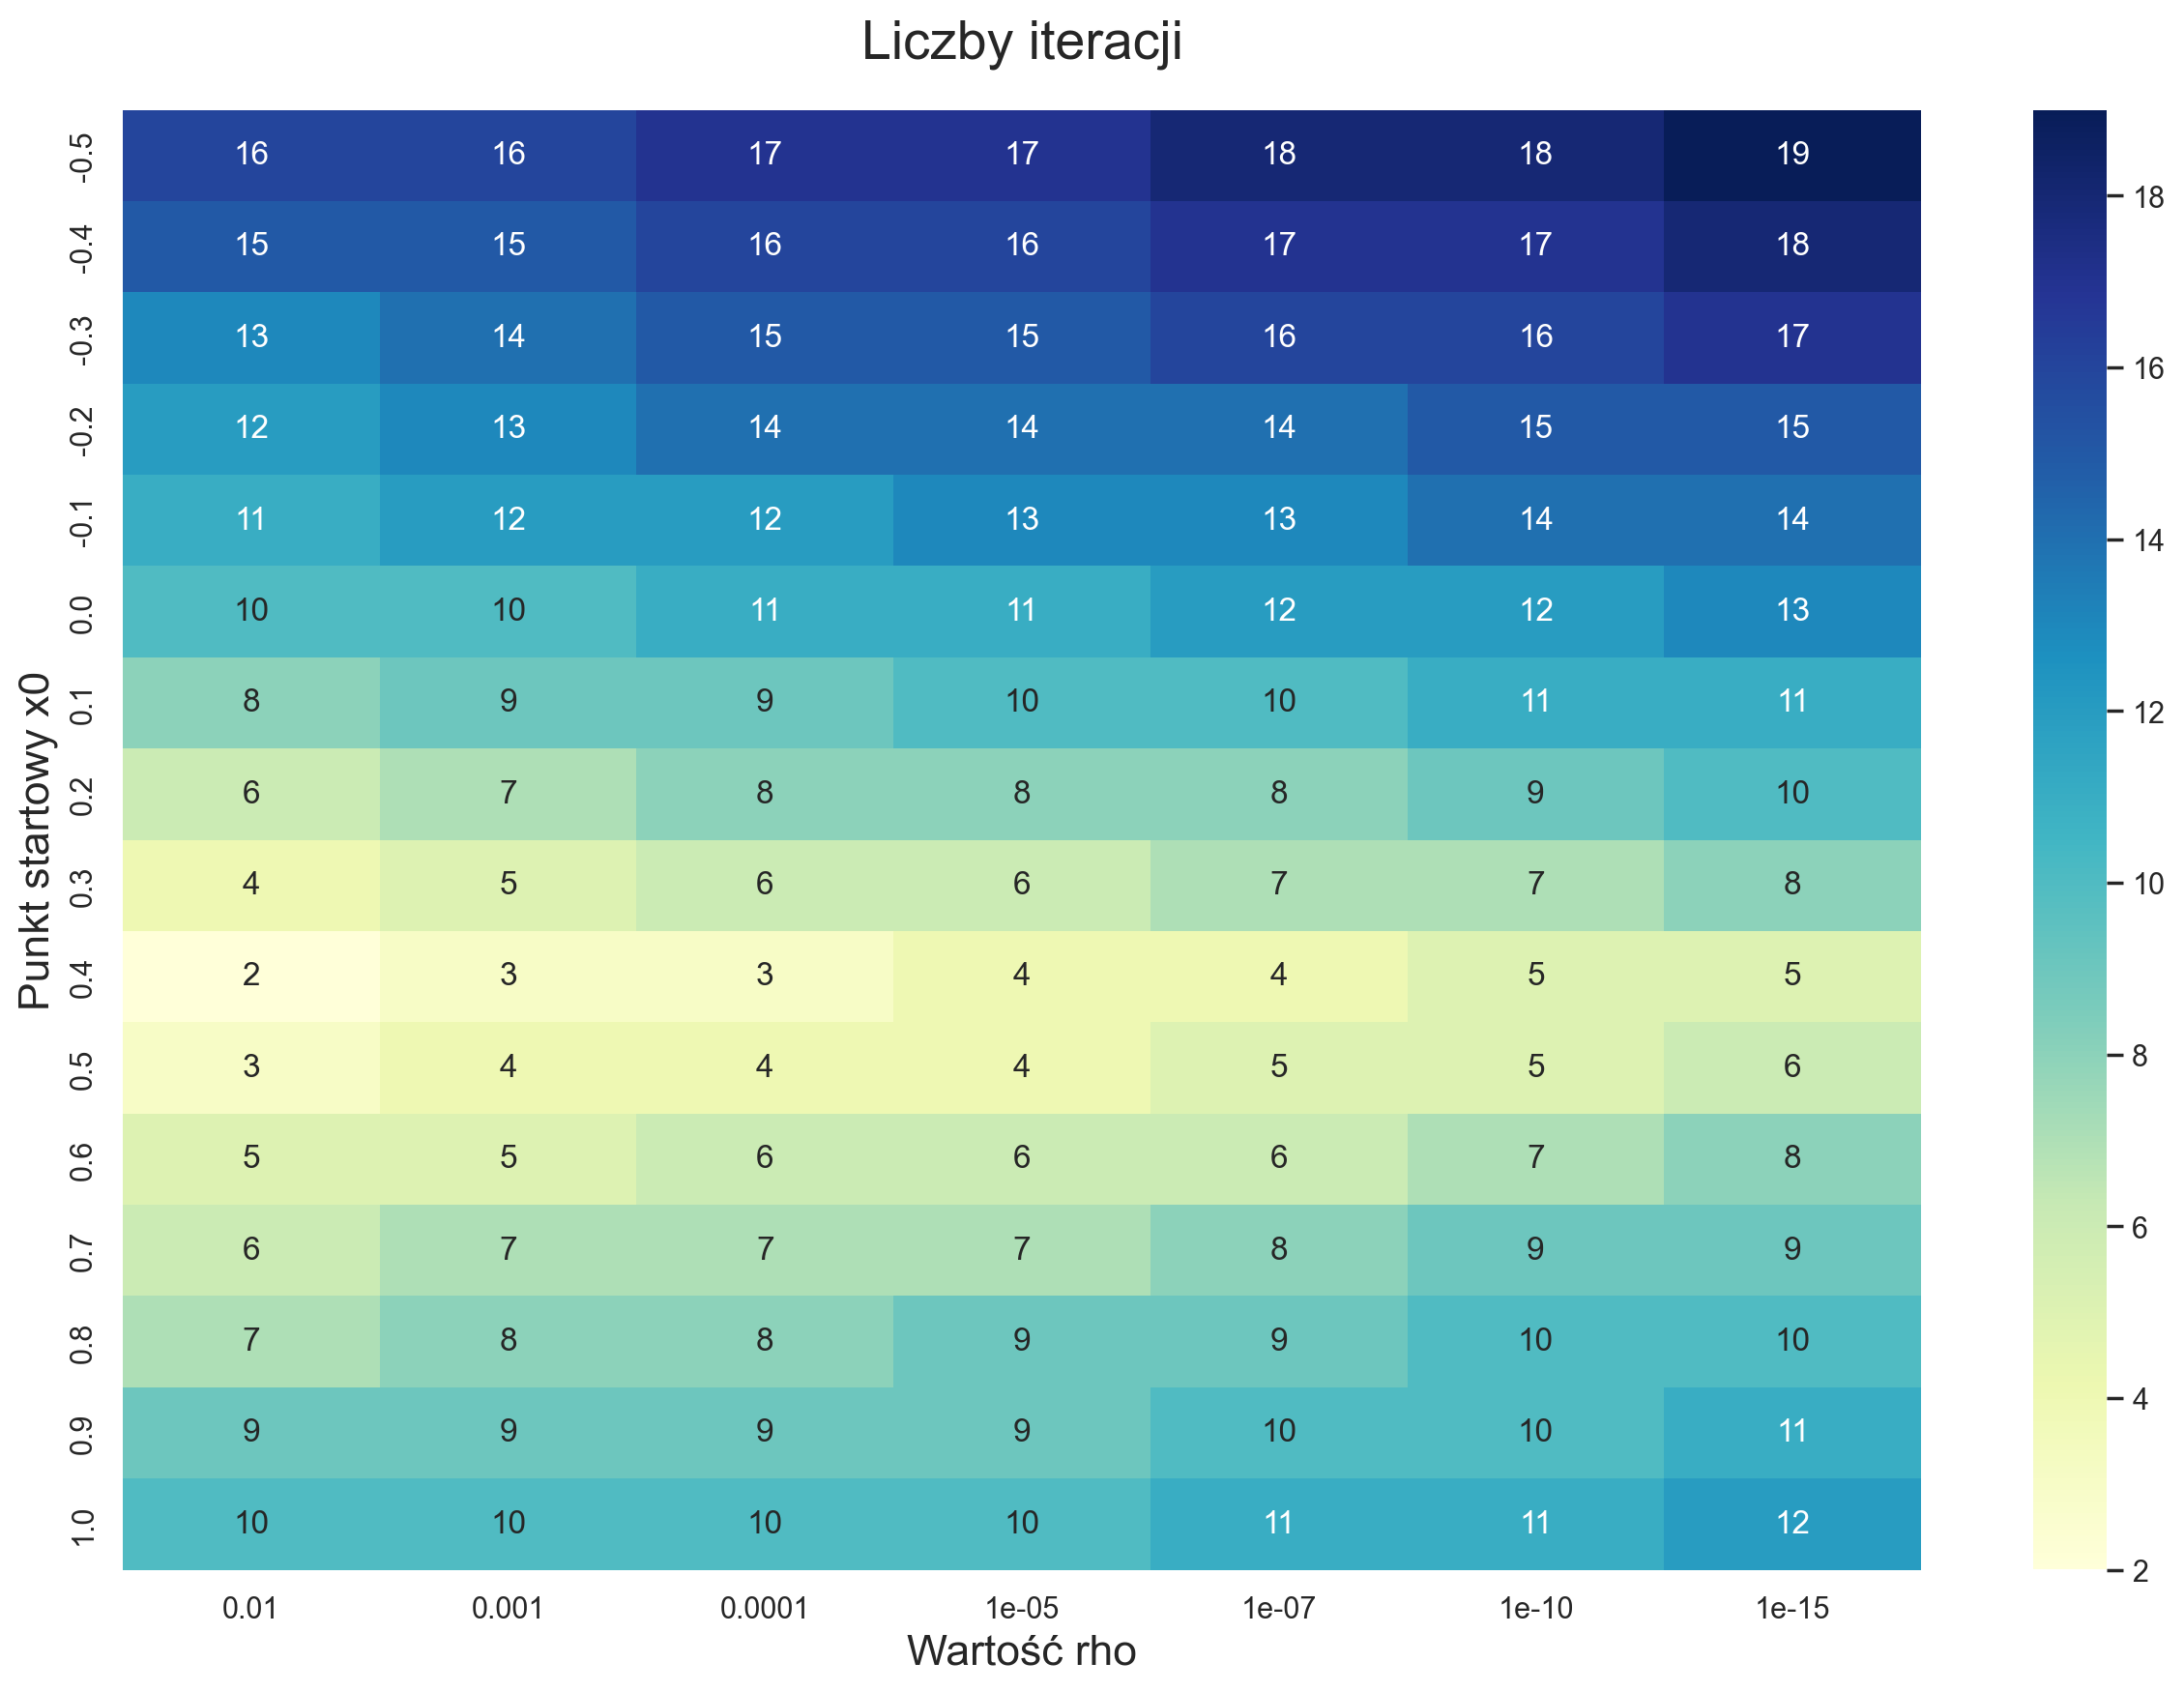

In [424]:
show_heatmap(df1.applymap(lambda cell: cell[1]), 
             xlabel='Wartość rho', ylabel='Punkt startowy x0', title='Liczby iteracji')

###### Błędy

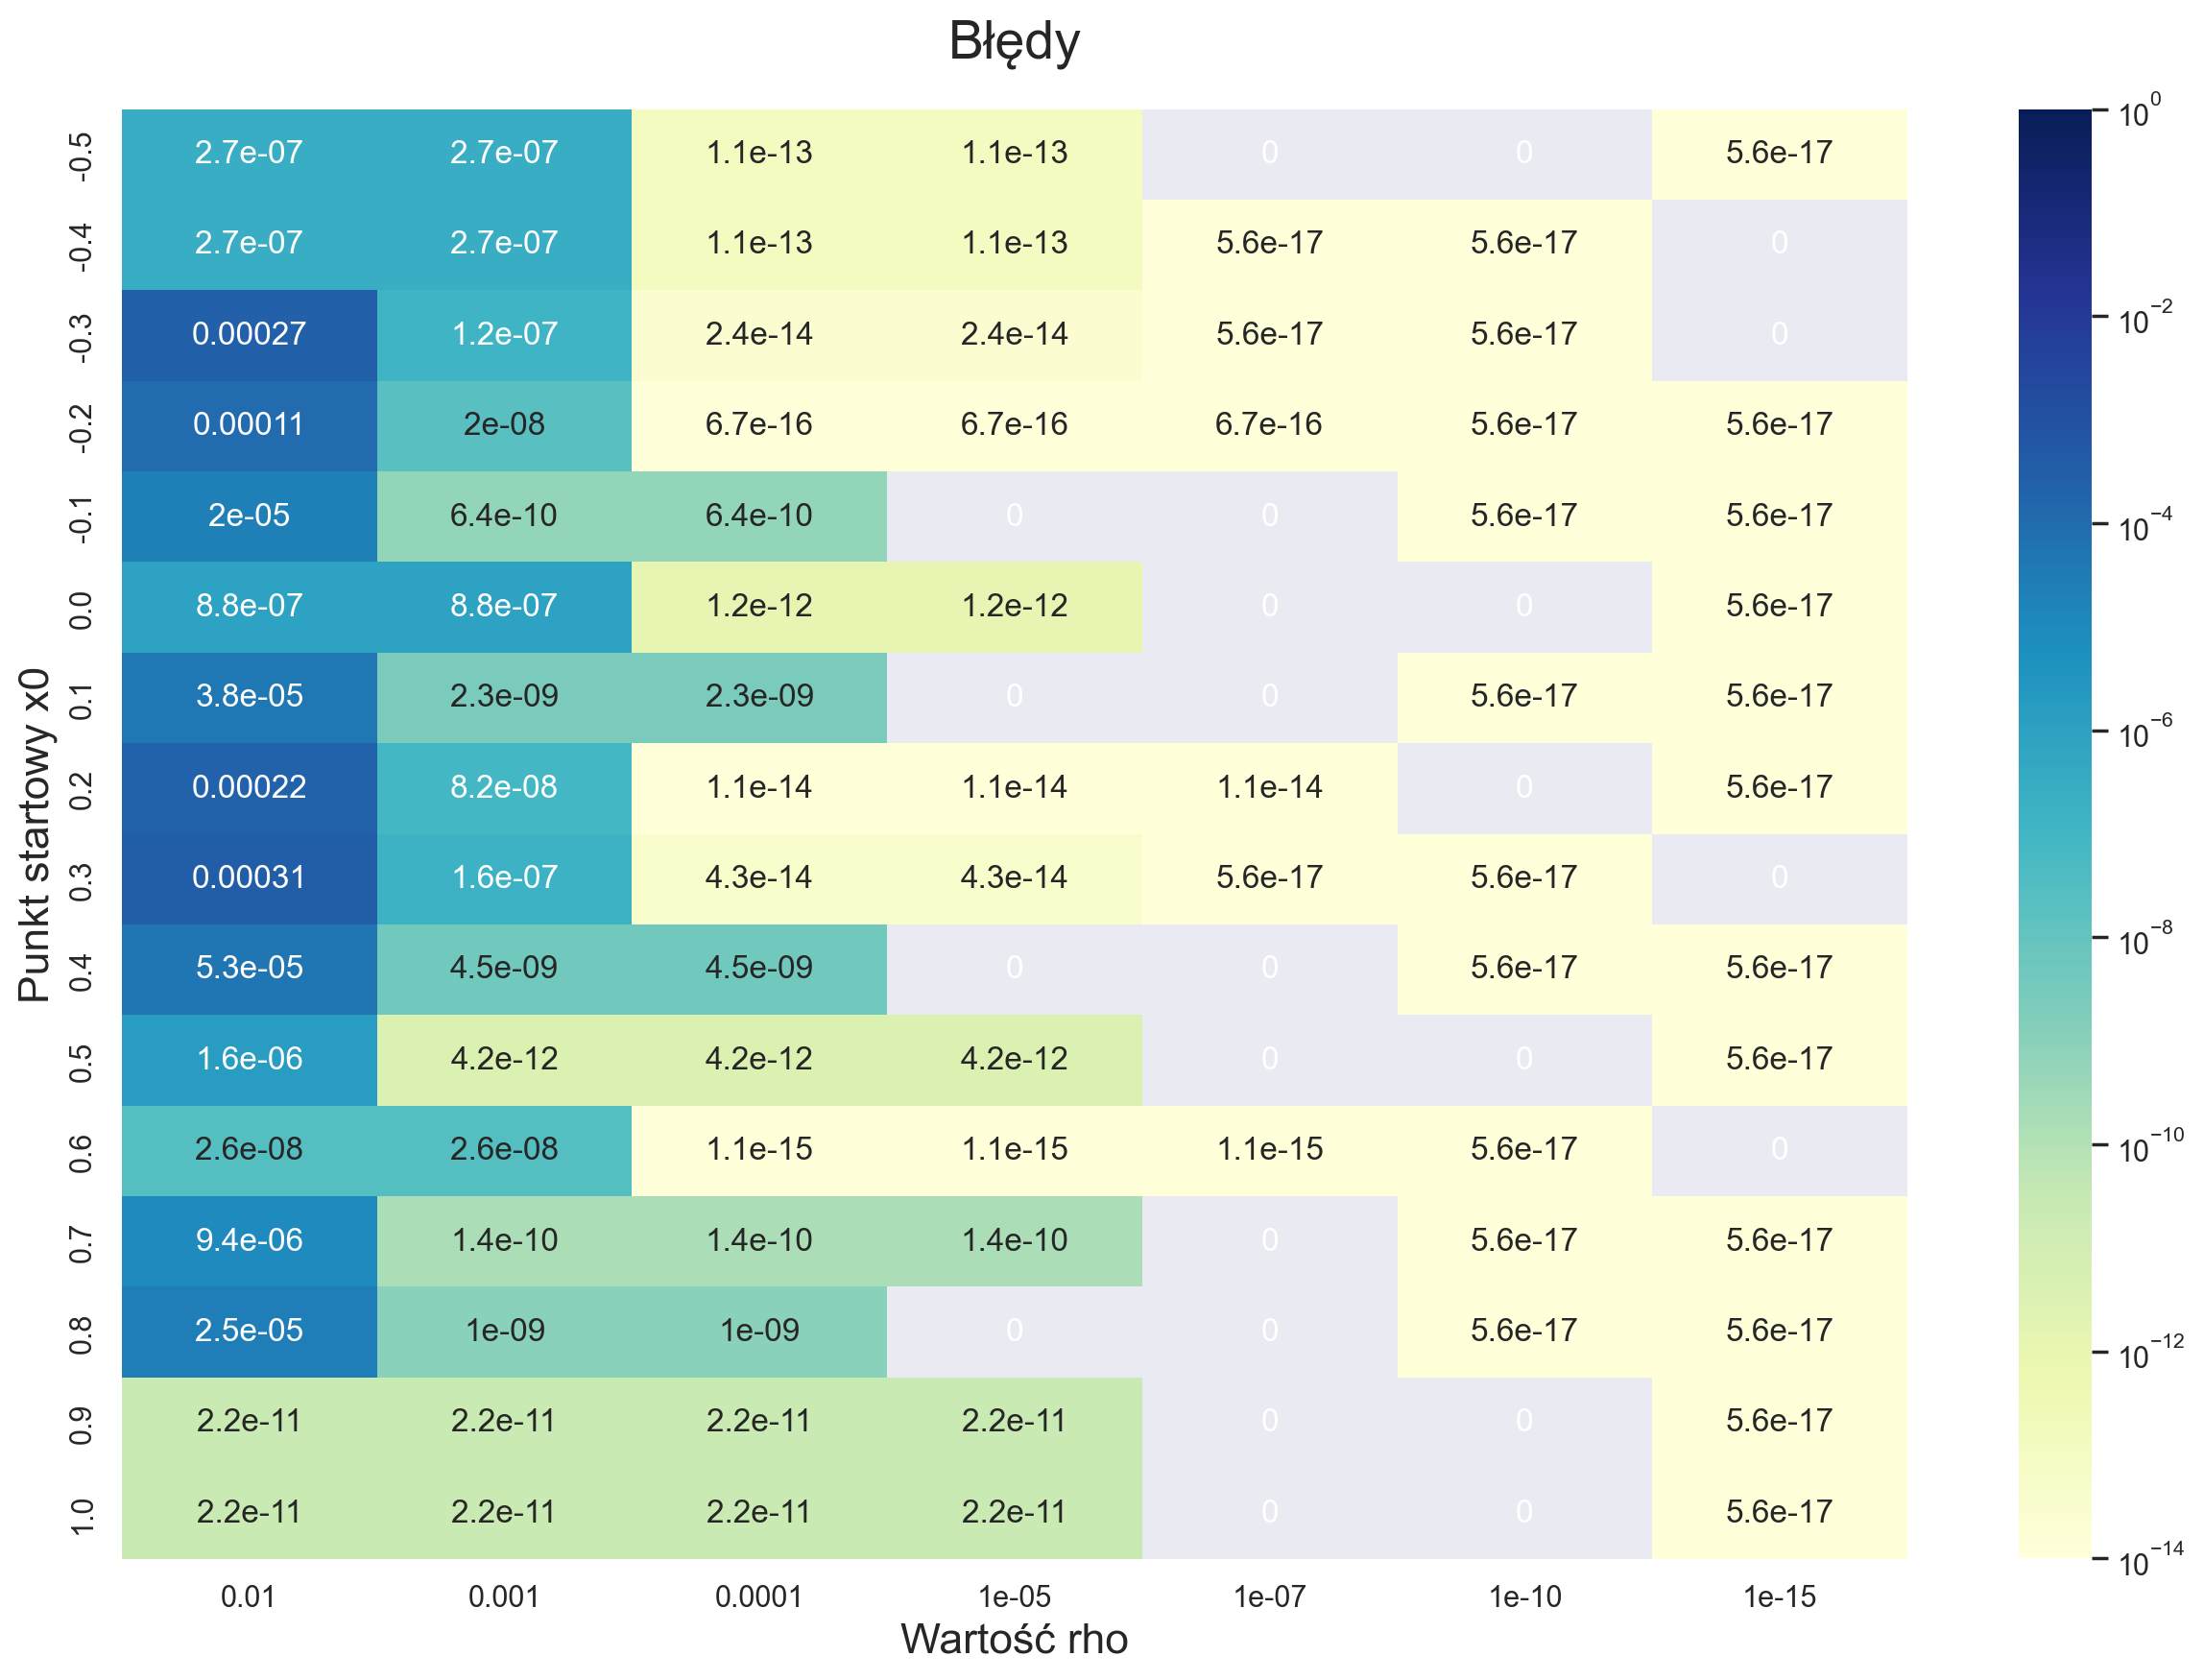

In [425]:
err_df = abs(df1.applymap(lambda cell: cell[0]) - expected_x)
show_heatmap(err_df, xlabel='Wartość rho', ylabel='Punkt startowy x0', title='Błędy', 
             norm=LogNorm(vmin=10e-15, vmax=10e-1))

##### Rezultaty dla kryterium 2.

In [426]:
df2 = calculate(a, b, stop_criterion_init2, [
    1e-2, 1e-3, 1e-4, 1e-5, 1e-7, 1e-10, 1e-15
])

###### Wyniki

In [427]:
df2.applymap(lambda cell: cell[0])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
-0.5,0.297734,0.386835,0.429762,0.429762,0.430159,0.43016,0.43016
-0.4,0.297734,0.386835,0.429762,0.429762,0.430159,0.43016,0.43016
-0.3,0.301314,0.389712,0.429888,0.429888,0.430160,0.43016,0.43016
-0.2,0.308985,0.395736,0.423644,0.430049,0.430160,0.43016,0.43016
-0.1,0.272866,0.404871,0.427072,0.430140,0.430160,0.43016,0.43016
0.0,0.291748,0.381951,0.429446,0.429446,0.430159,0.43016,0.43016
0.1,0.268265,0.401783,0.426065,0.430122,0.430160,0.43016,0.43016
0.2,0.303098,0.391131,0.421422,0.429937,0.430160,0.43016,0.43016
0.3,0.300000,0.388660,0.429847,0.429847,0.430160,0.43016,0.43016
0.4,0.400000,0.400000,0.425412,0.430107,0.430160,0.43016,0.43016


###### Liczby iteracji

In [428]:
df2.applymap(lambda cell: cell[1])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
-0.5,11,13,15,15,16,17,18
-0.4,10,12,14,14,15,16,17
-0.3,9,11,13,13,14,15,15
-0.2,8,10,11,12,13,14,14
-0.1,6,9,10,11,12,12,13
0.0,5,7,9,9,10,11,12
0.1,3,6,7,8,9,9,10
0.2,2,4,5,6,7,8,8
0.3,0,2,4,4,5,6,6
0.4,0,0,1,2,3,3,4


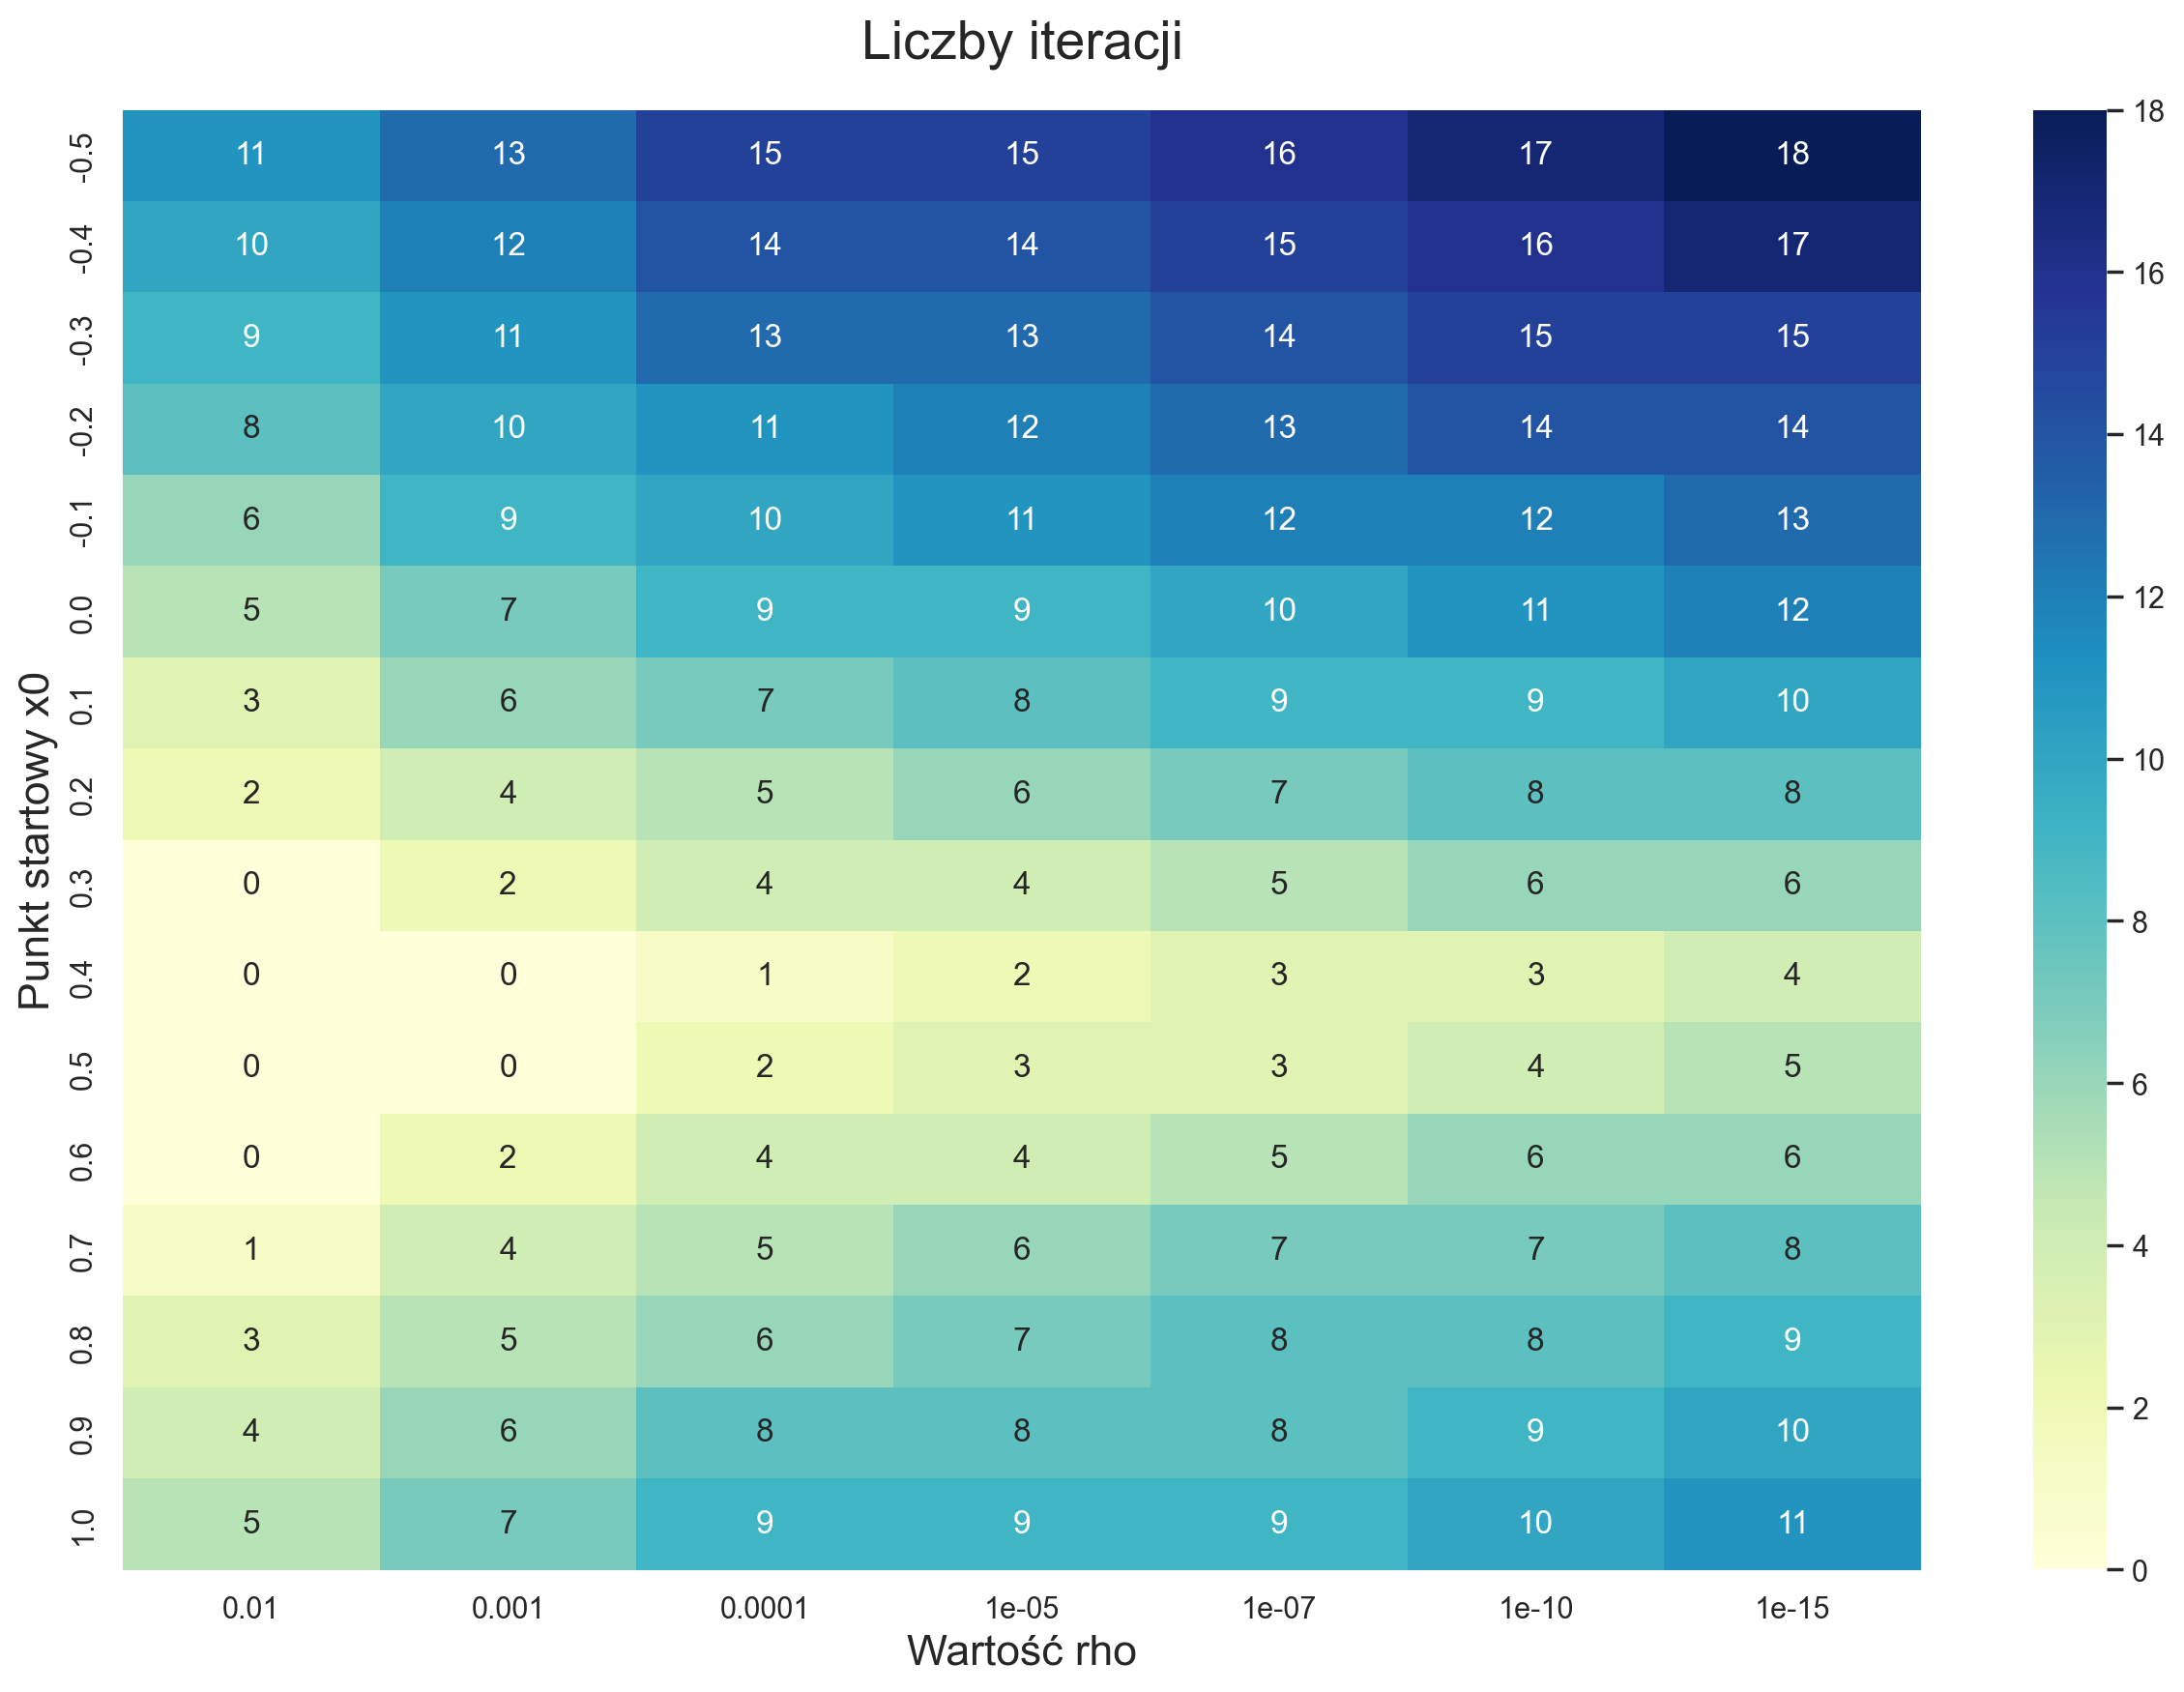

In [429]:
show_heatmap(df2.applymap(lambda cell: cell[1]), 
             xlabel='Wartość rho', ylabel='Punkt startowy x0', title='Liczby iteracji')

###### Błędy

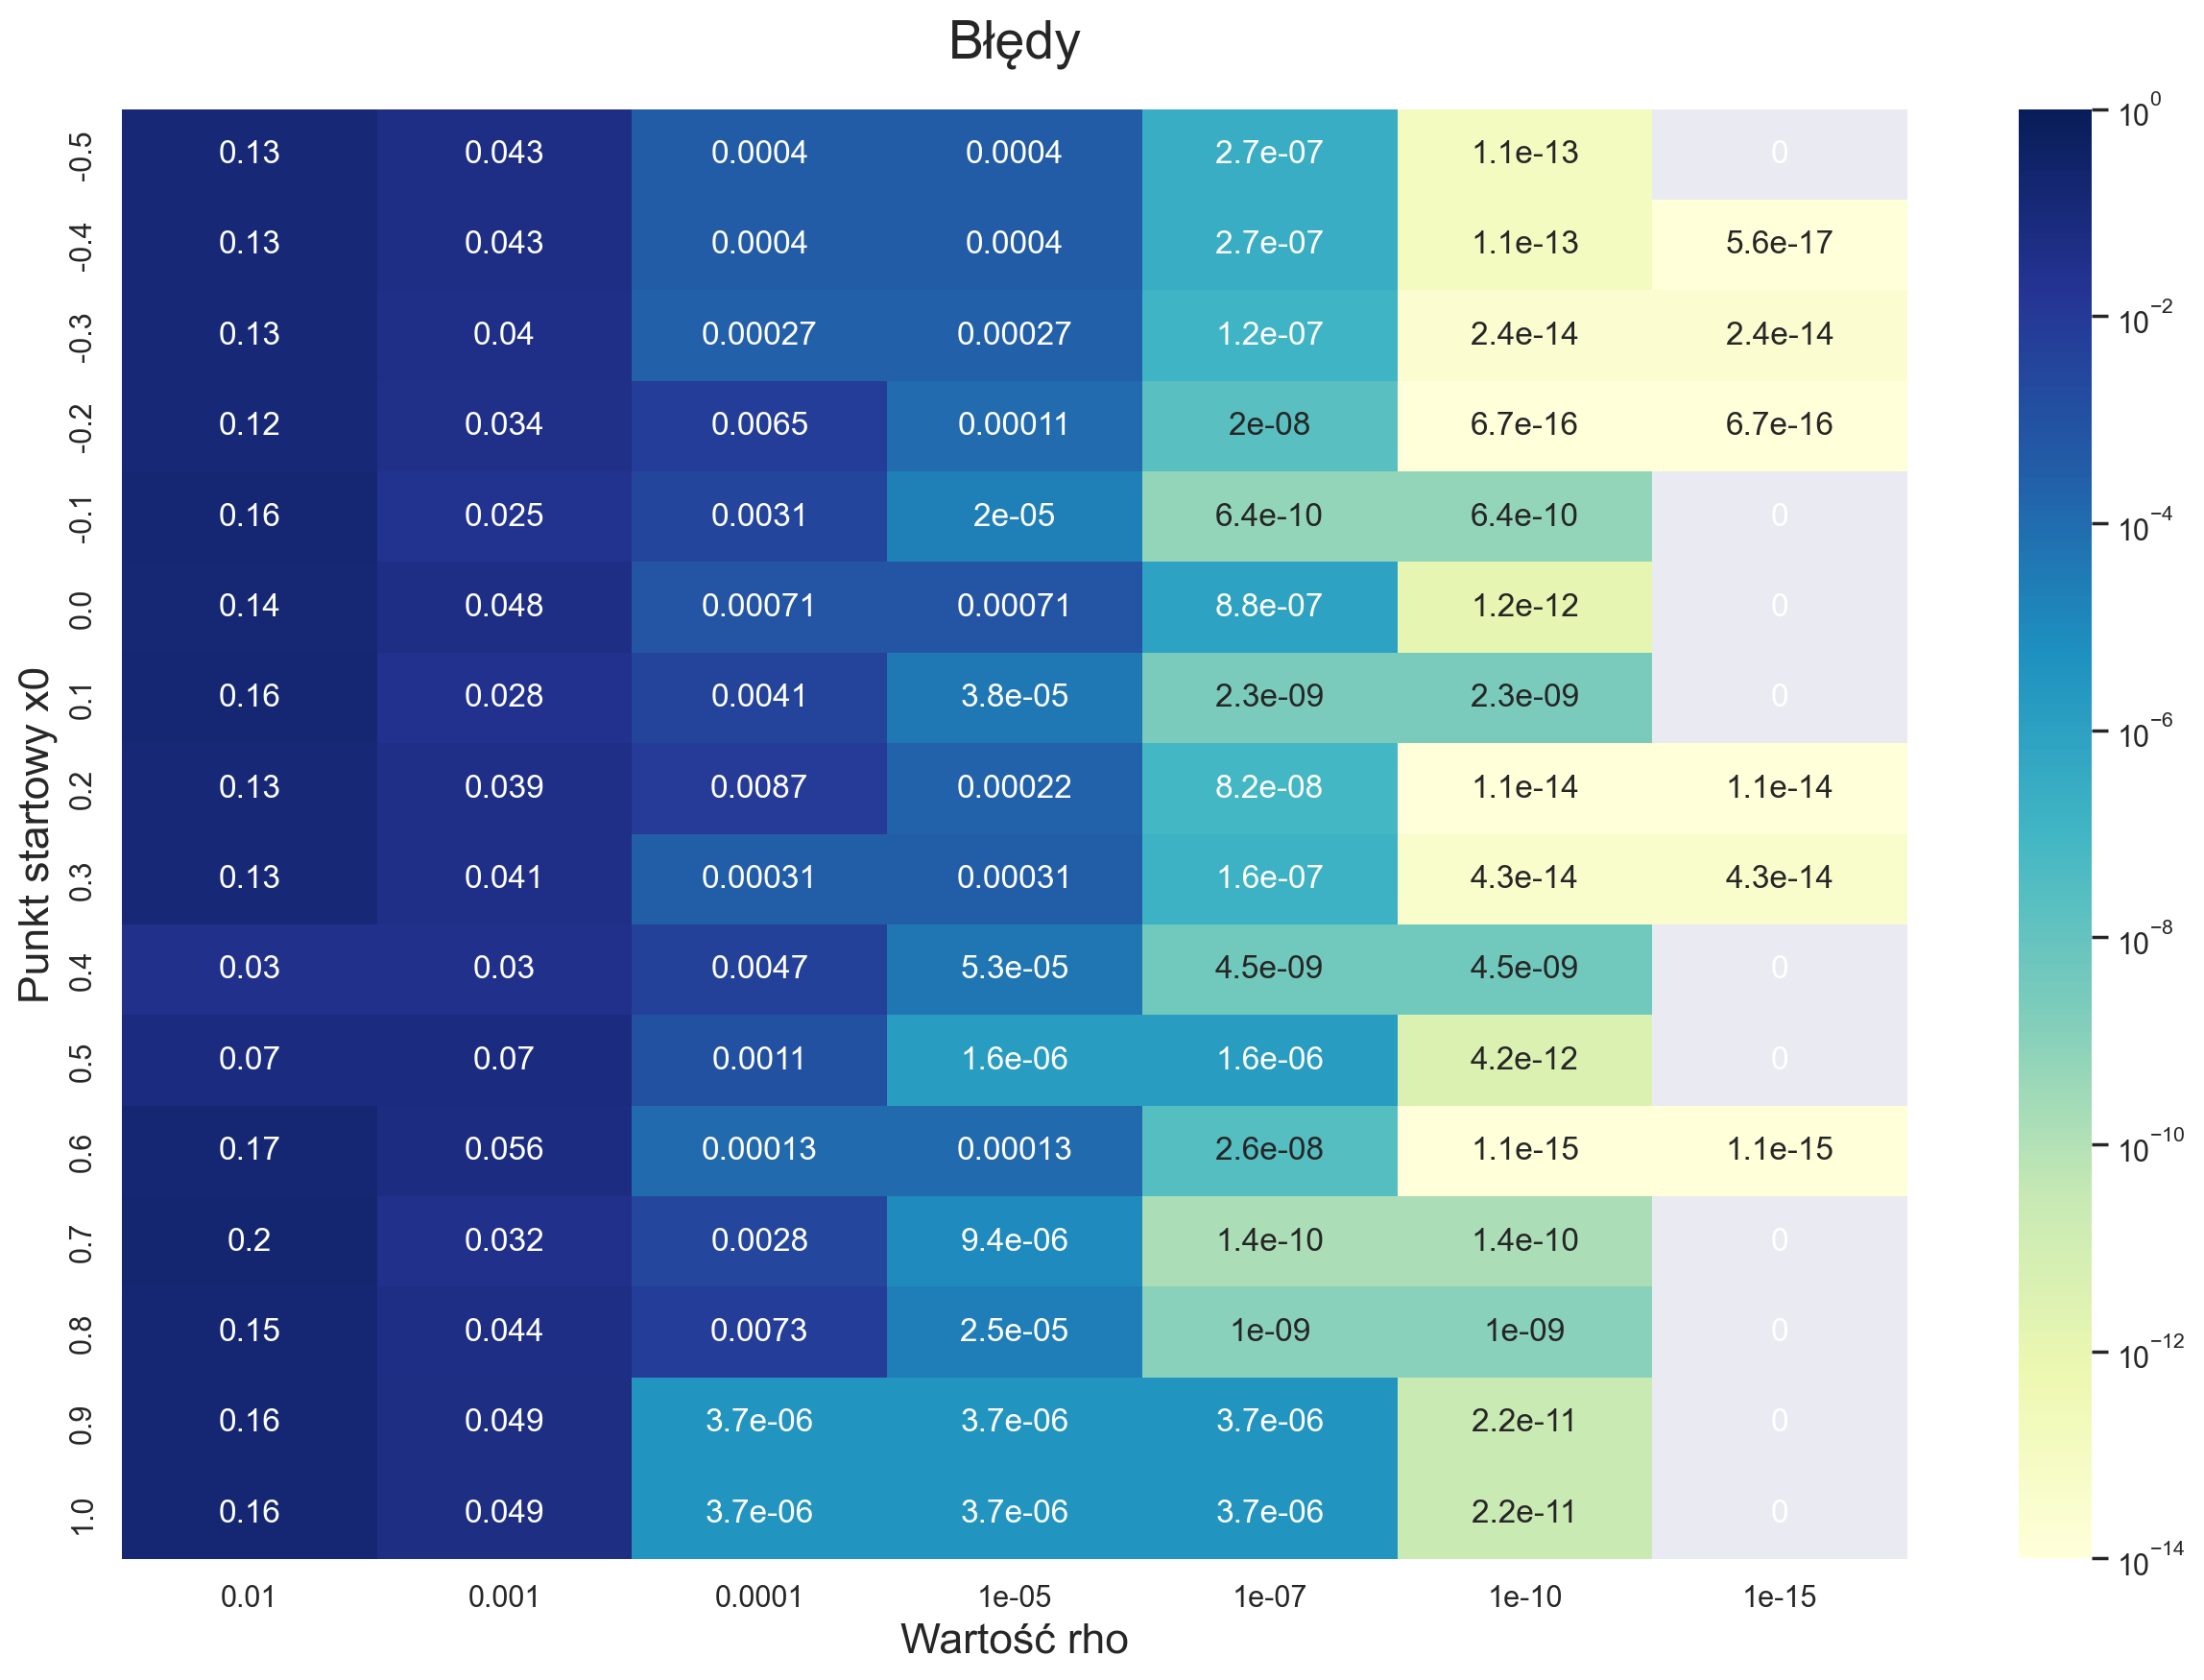

In [430]:
err_df = abs(df2.applymap(lambda cell: cell[0]) - expected_x)
show_heatmap(err_df, xlabel='Wartość rho', ylabel='Punkt startowy x0', title='Błędy', 
             norm=LogNorm(vmin=10e-15, vmax=10e-1))

## Metoda siecznych

Korzystamy ze wzoru iteracyjnego:

$\Large{x_{i+2} = x_{i+1} - \frac{x_{i+1} - x_i}{f(x_{i+1}) - f(x_i)} \cdot f(x_{i + 1})}$

### Implementacja

In [431]:
def calc_xi2(f, xi0, xi1):
    return xi1 - (xi1 - xi0) / (f(xi1) - f(xi0)) * f(xi1)

def secant_method(f, x0, x1, stop_criterion):
    xi0 = None
    xi1 = x0
    xi2 = x1
    iters = 0
    
    while not stop_criterion(f, xi1, xi2):
        xi2, xi1, xi0 = calc_xi2(f, xi2, xi1), xi2, xi1
        iters += 1
        
    return xi2, iters

### Badanie funkcji

#### Przykłady

In [432]:
𝜌 = .000000000000001
secant_method(lambdify(x, f), -.5, -.4, stop_criterion_init1(𝜌))

(0.4301597090019468, 25)

In [433]:
𝜌 = .000000000000001
secant_method(lambdify(x, f), b, a, stop_criterion_init1(𝜌))

(0.4301597090019468, 19)

#### Wyznaczanie liczby iteracji oraz wyników dla różnych punktów startowych i różnych kryteriów stopu

##### Pomocnicza funkcja

In [455]:
def calculate(a, b, x1, stop_criterion_init, 𝜌_list, step=.1):
    if not a <= x1 <= b:
        raise Exception(f'x1={x1} is not between {a} and {b}')
        
    if x1 - a < b - x1:
        a = x1
    else:
        b = x1
    
    n = int(abs(b - a) / step + .5)
    if a == x1:
        x0_list = [a + step * i for i in range(1, n)] + [b]
    else:
        x0_list = [a + step * i for i in range(n)]
        
    stop_criterions = list(map(stop_criterion_init, 𝜌_list))
    dec_places = len(str(int(1 / step + .5)))
    
    df = pd.DataFrame(
        columns=𝜌_list, 
        index=[(round(min(x0, x1), dec_places), round(max(x0, x1), dec_places)) 
               for x0 in x0_list]
    )
    
    f_lambd = lambdify(x, f)
    for i, x0 in enumerate(x0_list):
        for j in range(len(𝜌_list)):
            df.iloc[i, j] = secant_method(f_lambd, x0, x1, stop_criterions[j])
            
    return df

##### Rezultaty dla kryterium 1.

###### Dla ustalonej wartości początku przedziału

In [474]:
df1 = calculate(a, b, a, stop_criterion_init1, [
    1e-2, 1e-3, 1e-4, 1e-5, 1e-7, 1e-10, 1e-15
])

**Wyniki**

In [475]:
df1.applymap(lambda cell: cell[0])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
"(-0.5, -0.4)",0.430050,0.430159,0.430160,0.430160,0.43016,0.43016,0.43016
"(-0.5, -0.3)",0.430041,0.430159,0.430160,0.430160,0.43016,0.43016,0.43016
"(-0.5, -0.2)",-0.179222,0.430160,0.430160,0.430160,0.43016,0.43016,0.43016
"(-0.5, -0.1)",-0.092459,0.430159,0.430160,0.430160,0.43016,0.43016,0.43016
"(-0.5, 0.0)",0.002272,0.430158,0.430160,0.430160,0.43016,0.43016,0.43016
"(-0.5, 0.1)",0.100563,0.100563,0.430159,0.430160,0.43016,0.43016,0.43016
"(-0.5, 0.2)",0.200112,0.200112,0.200112,0.430160,0.43016,0.43016,0.43016
"(-0.5, 0.3)",0.300017,0.300017,0.300017,0.300017,0.43016,0.43016,0.43016
"(-0.5, 0.4)",0.400002,0.400002,0.400002,0.400002,0.43016,0.43016,0.43016
"(-0.5, 0.5)",0.499996,0.499996,0.499996,0.499996,0.43016,0.43016,0.43016


**Liczby iteracji**

In [476]:
df1.applymap(lambda cell: cell[1])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
"(-0.5, -0.4)",21,22,23,23,24,24,25
"(-0.5, -0.3)",20,21,22,22,23,24,24
"(-0.5, -0.2)",2,20,20,21,21,22,23
"(-0.5, -0.1)",2,18,19,19,20,21,21
"(-0.5, 0.0)",2,16,17,17,18,19,19
"(-0.5, 0.1)",2,2,14,15,16,16,17
"(-0.5, 0.2)",2,2,2,13,13,14,15
"(-0.5, 0.3)",2,2,2,2,10,11,12
"(-0.5, 0.4)",2,2,2,2,7,8,9
"(-0.5, 0.5)",2,2,2,2,8,9,9


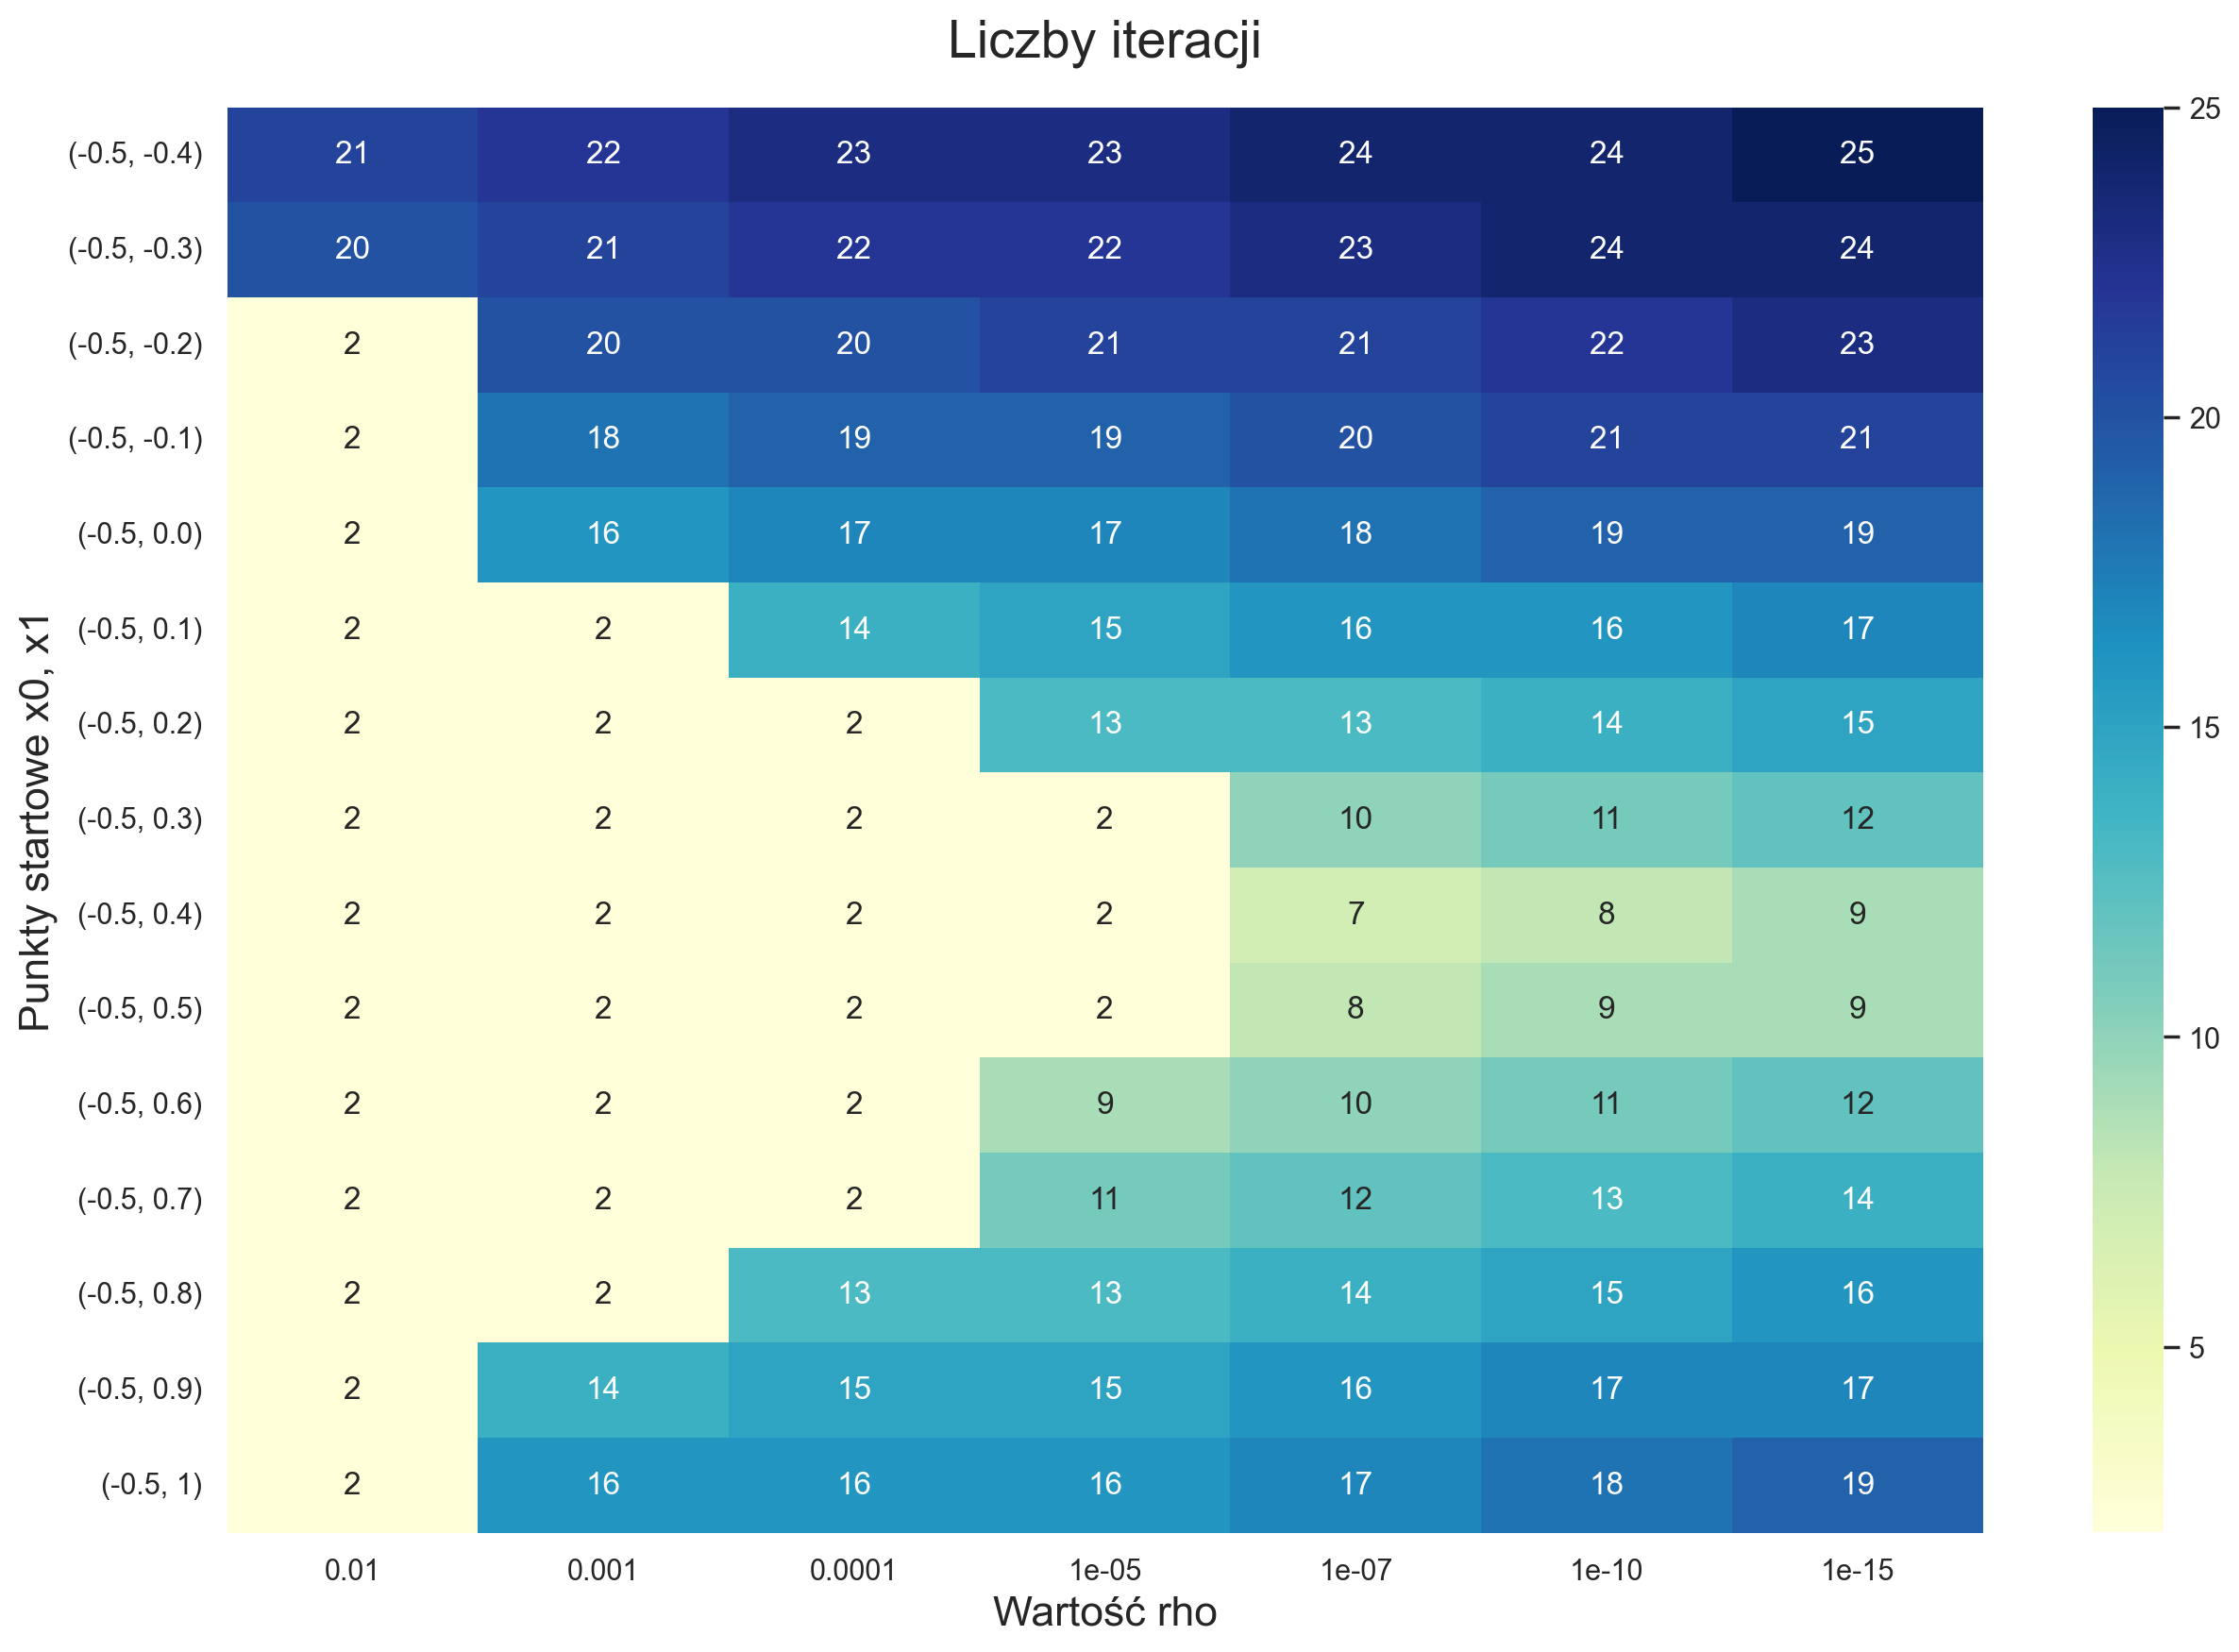

In [477]:
show_heatmap(df1.applymap(lambda cell: cell[1]), 
             xlabel='Wartość rho', ylabel='Punkty startowe x0, x1', title='Liczby iteracji')

**Błędy**

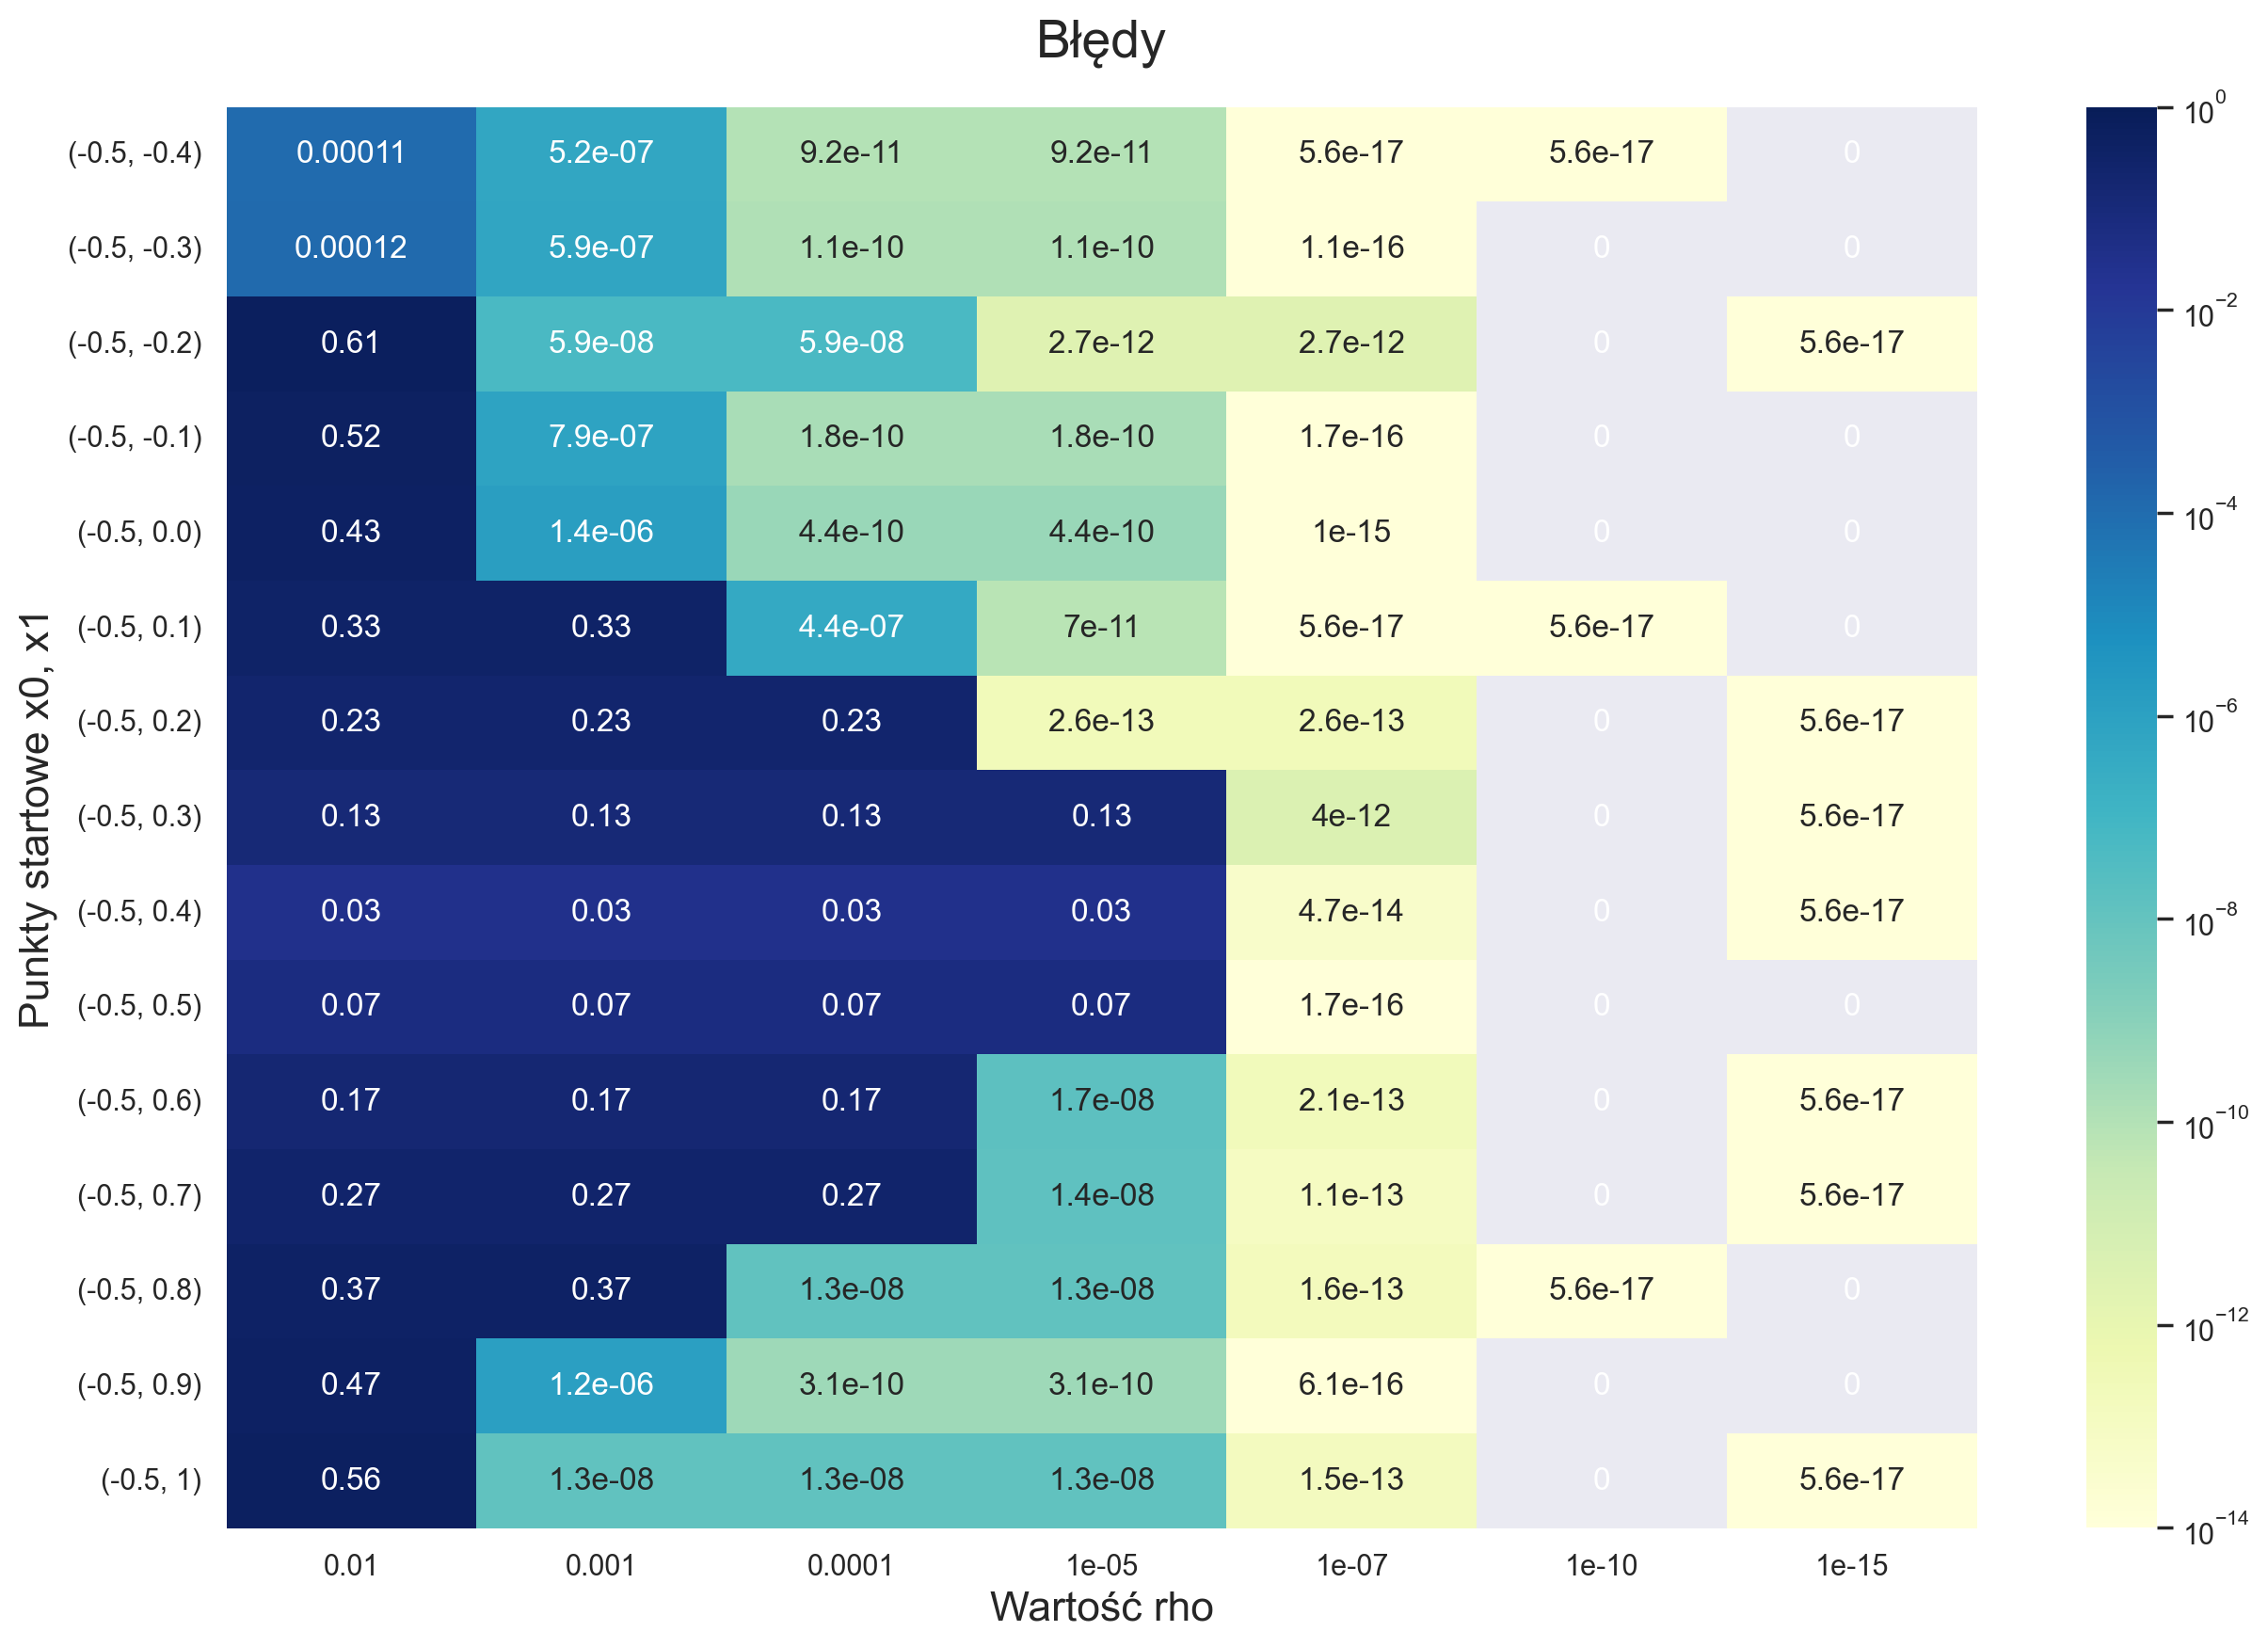

In [478]:
err_df = abs(df1.applymap(lambda cell: cell[0]) - expected_x)
show_heatmap(err_df, xlabel='Wartość rho', ylabel='Punkty startowe x0, x1', title='Błędy', 
             norm=LogNorm(vmin=10e-15, vmax=10e-1))

##### Dla ustalonej wartości końca przedziału

In [479]:
df1 = calculate(a, b, b, stop_criterion_init1, [
    1e-2, 1e-3, 1e-4, 1e-5, 1e-7, 1e-10, 1e-15
])

###### Wyniki

In [480]:
df1.applymap(lambda cell: cell[0])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
"(-0.5, 1)",0.996582,0.430160,0.430160,0.43016,0.43016,0.43016,0.43016
"(-0.4, 1)",0.991058,0.430160,0.430160,0.43016,0.43016,0.43016,0.43016
"(-0.3, 1)",0.430768,0.430155,0.430160,0.43016,0.43016,0.43016,0.43016
"(-0.2, 1)",0.430184,0.430160,0.430160,0.43016,0.43016,0.43016,0.43016
"(-0.1, 1)",0.430286,0.430159,0.430160,0.43016,0.43016,0.43016,0.43016
"(0.0, 1)",0.499527,0.499527,0.430160,0.43016,0.43016,0.43016,0.43016
"(0.1, 1)",0.262817,0.430159,0.430159,0.43016,0.43016,0.43016,0.43016
"(0.2, 1)",0.429447,0.430148,0.430160,0.43016,0.43016,0.43016,0.43016
"(0.3, 1)",0.306366,0.430144,0.430160,0.43016,0.43016,0.43016,0.43016
"(0.4, 1)",0.400436,0.400436,0.430160,0.43016,0.43016,0.43016,0.43016


###### Liczby iteracji

In [481]:
df1.applymap(lambda cell: cell[1])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
"(-0.5, 1)",1,15,15,15,16,17,18
"(-0.4, 1)",1,15,15,15,16,17,18
"(-0.3, 1)",13,14,15,15,16,17,18
"(-0.2, 1)",13,14,14,15,16,16,17
"(-0.1, 1)",11,12,13,13,14,15,15
"(0.0, 1)",2,2,7,7,8,9,9
"(0.1, 1)",2,10,10,11,12,12,13
"(0.2, 1)",9,10,11,12,12,13,14
"(0.3, 1)",2,8,9,10,10,11,12
"(0.4, 1)",2,2,6,6,7,8,9


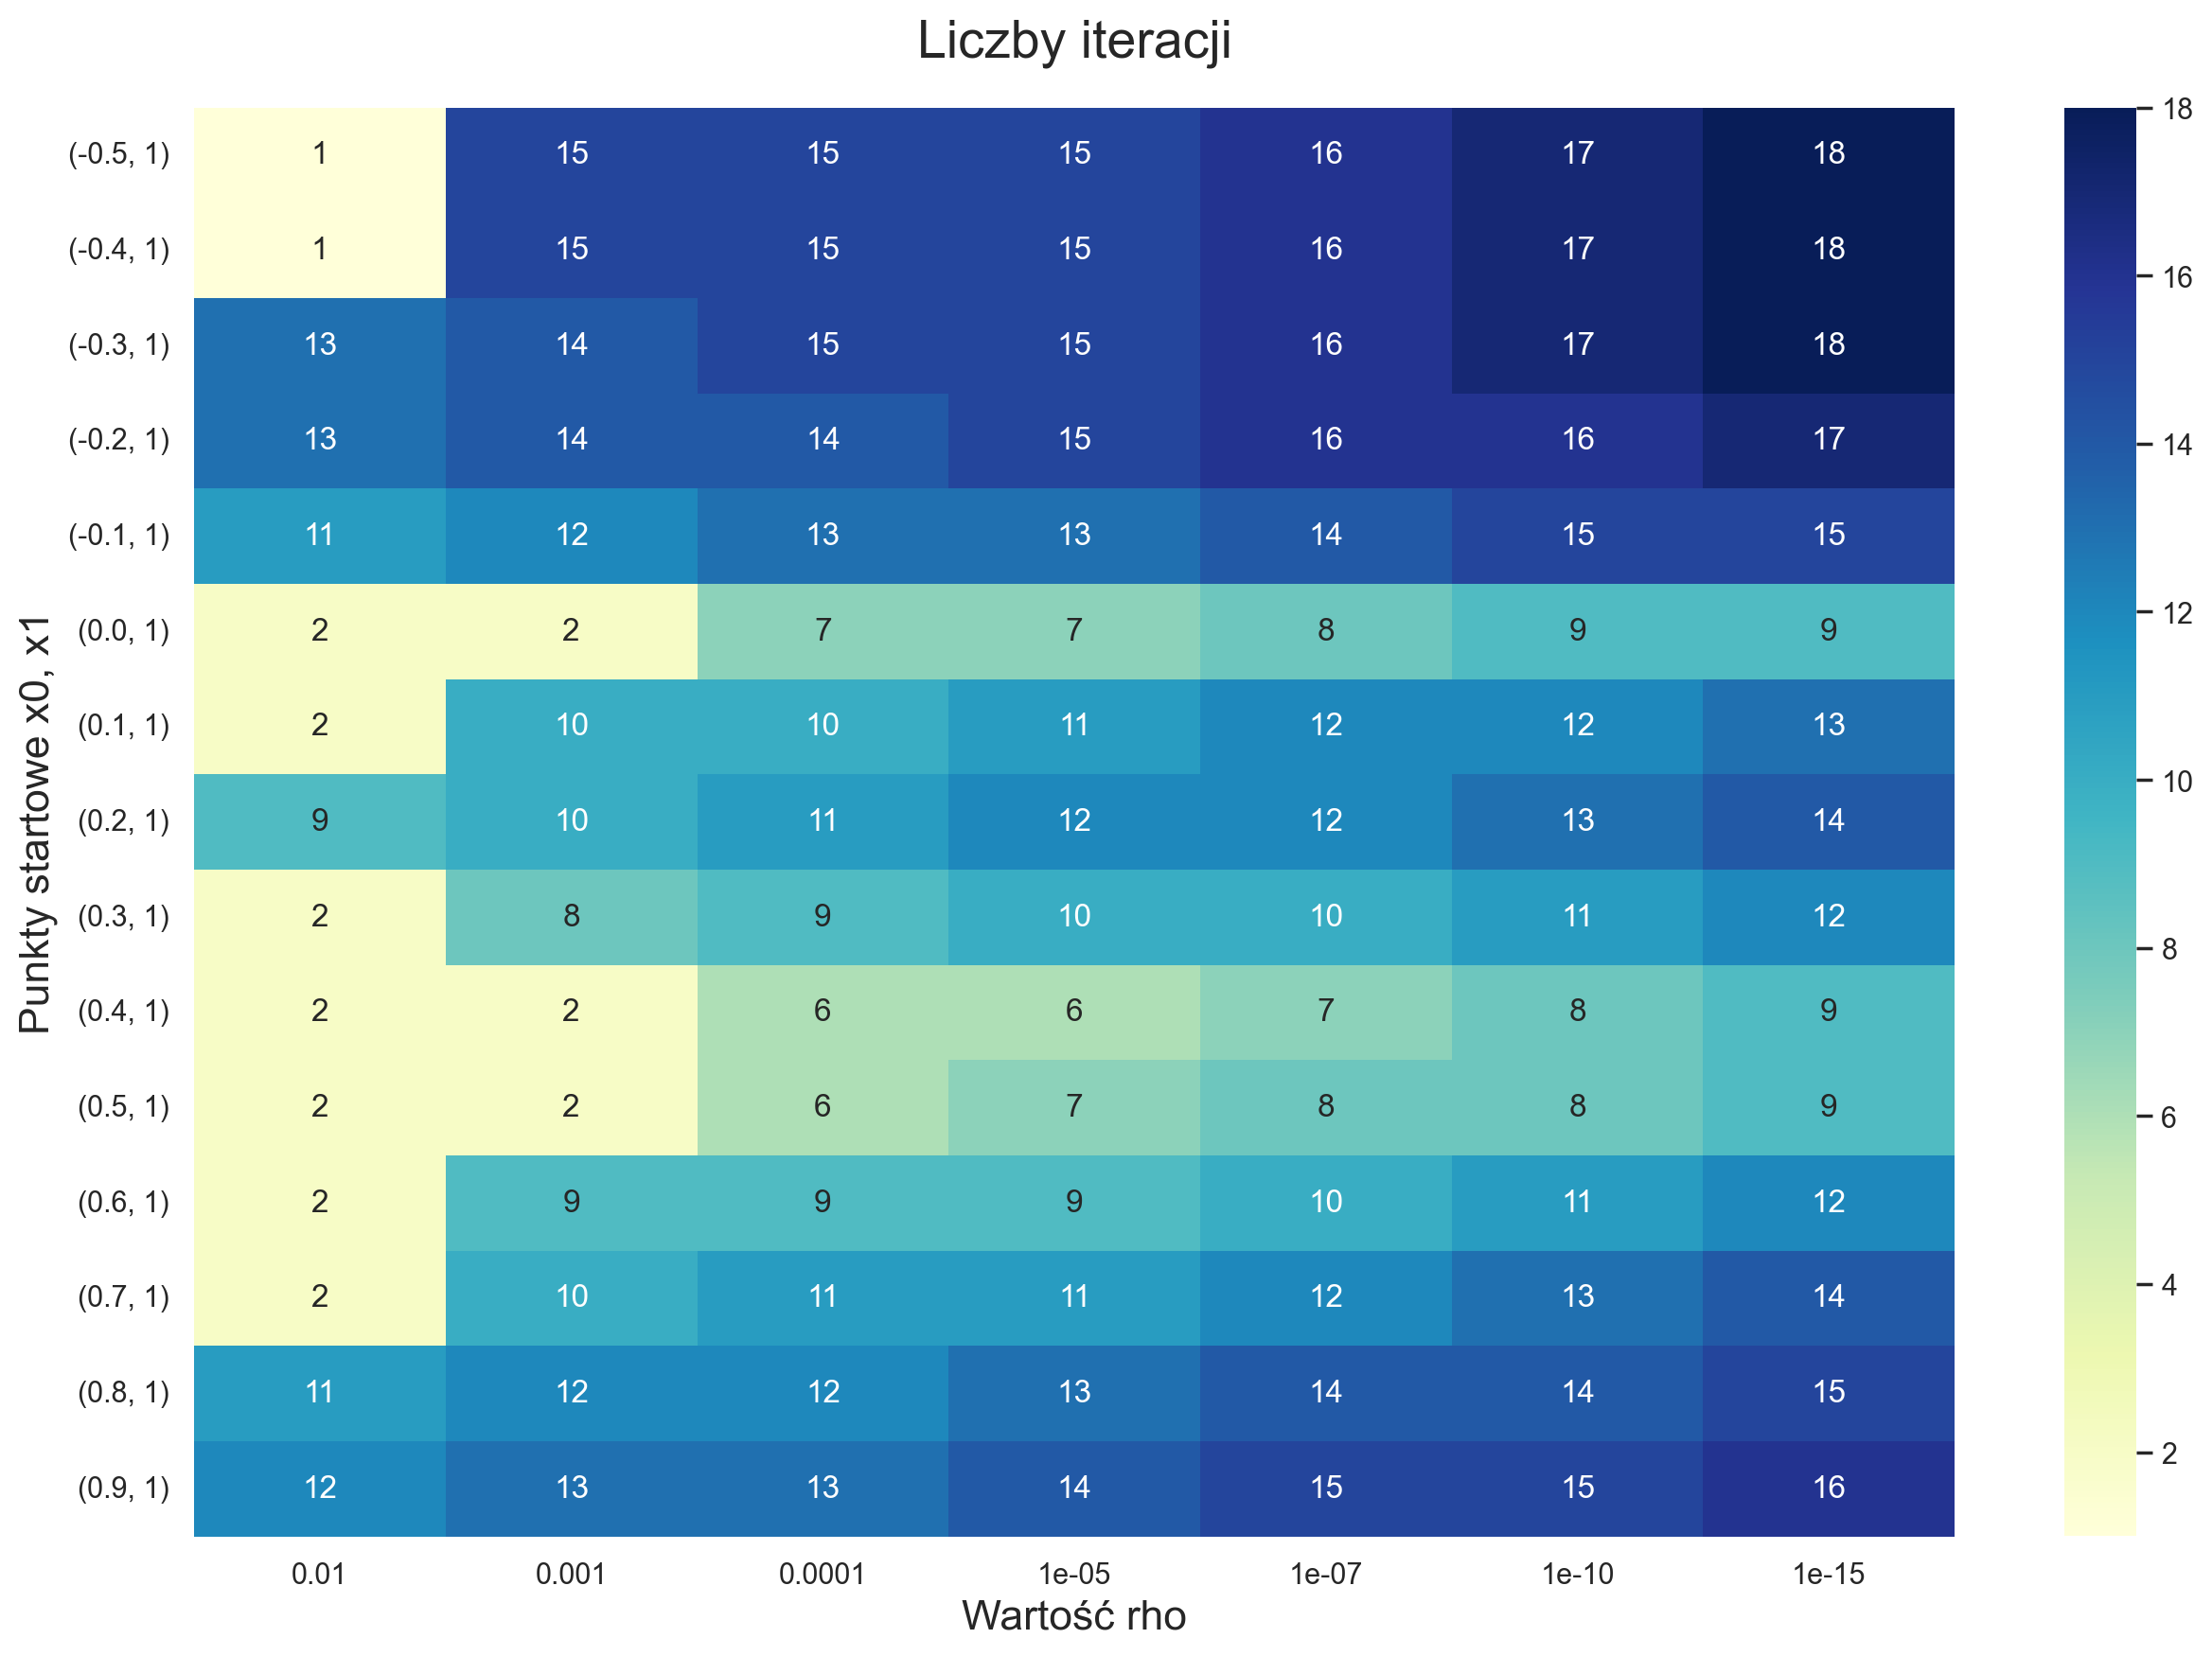

In [482]:
show_heatmap(df1.applymap(lambda cell: cell[1]), 
             xlabel='Wartość rho', ylabel='Punkty startowe x0, x1', title='Liczby iteracji')

##### Błędy

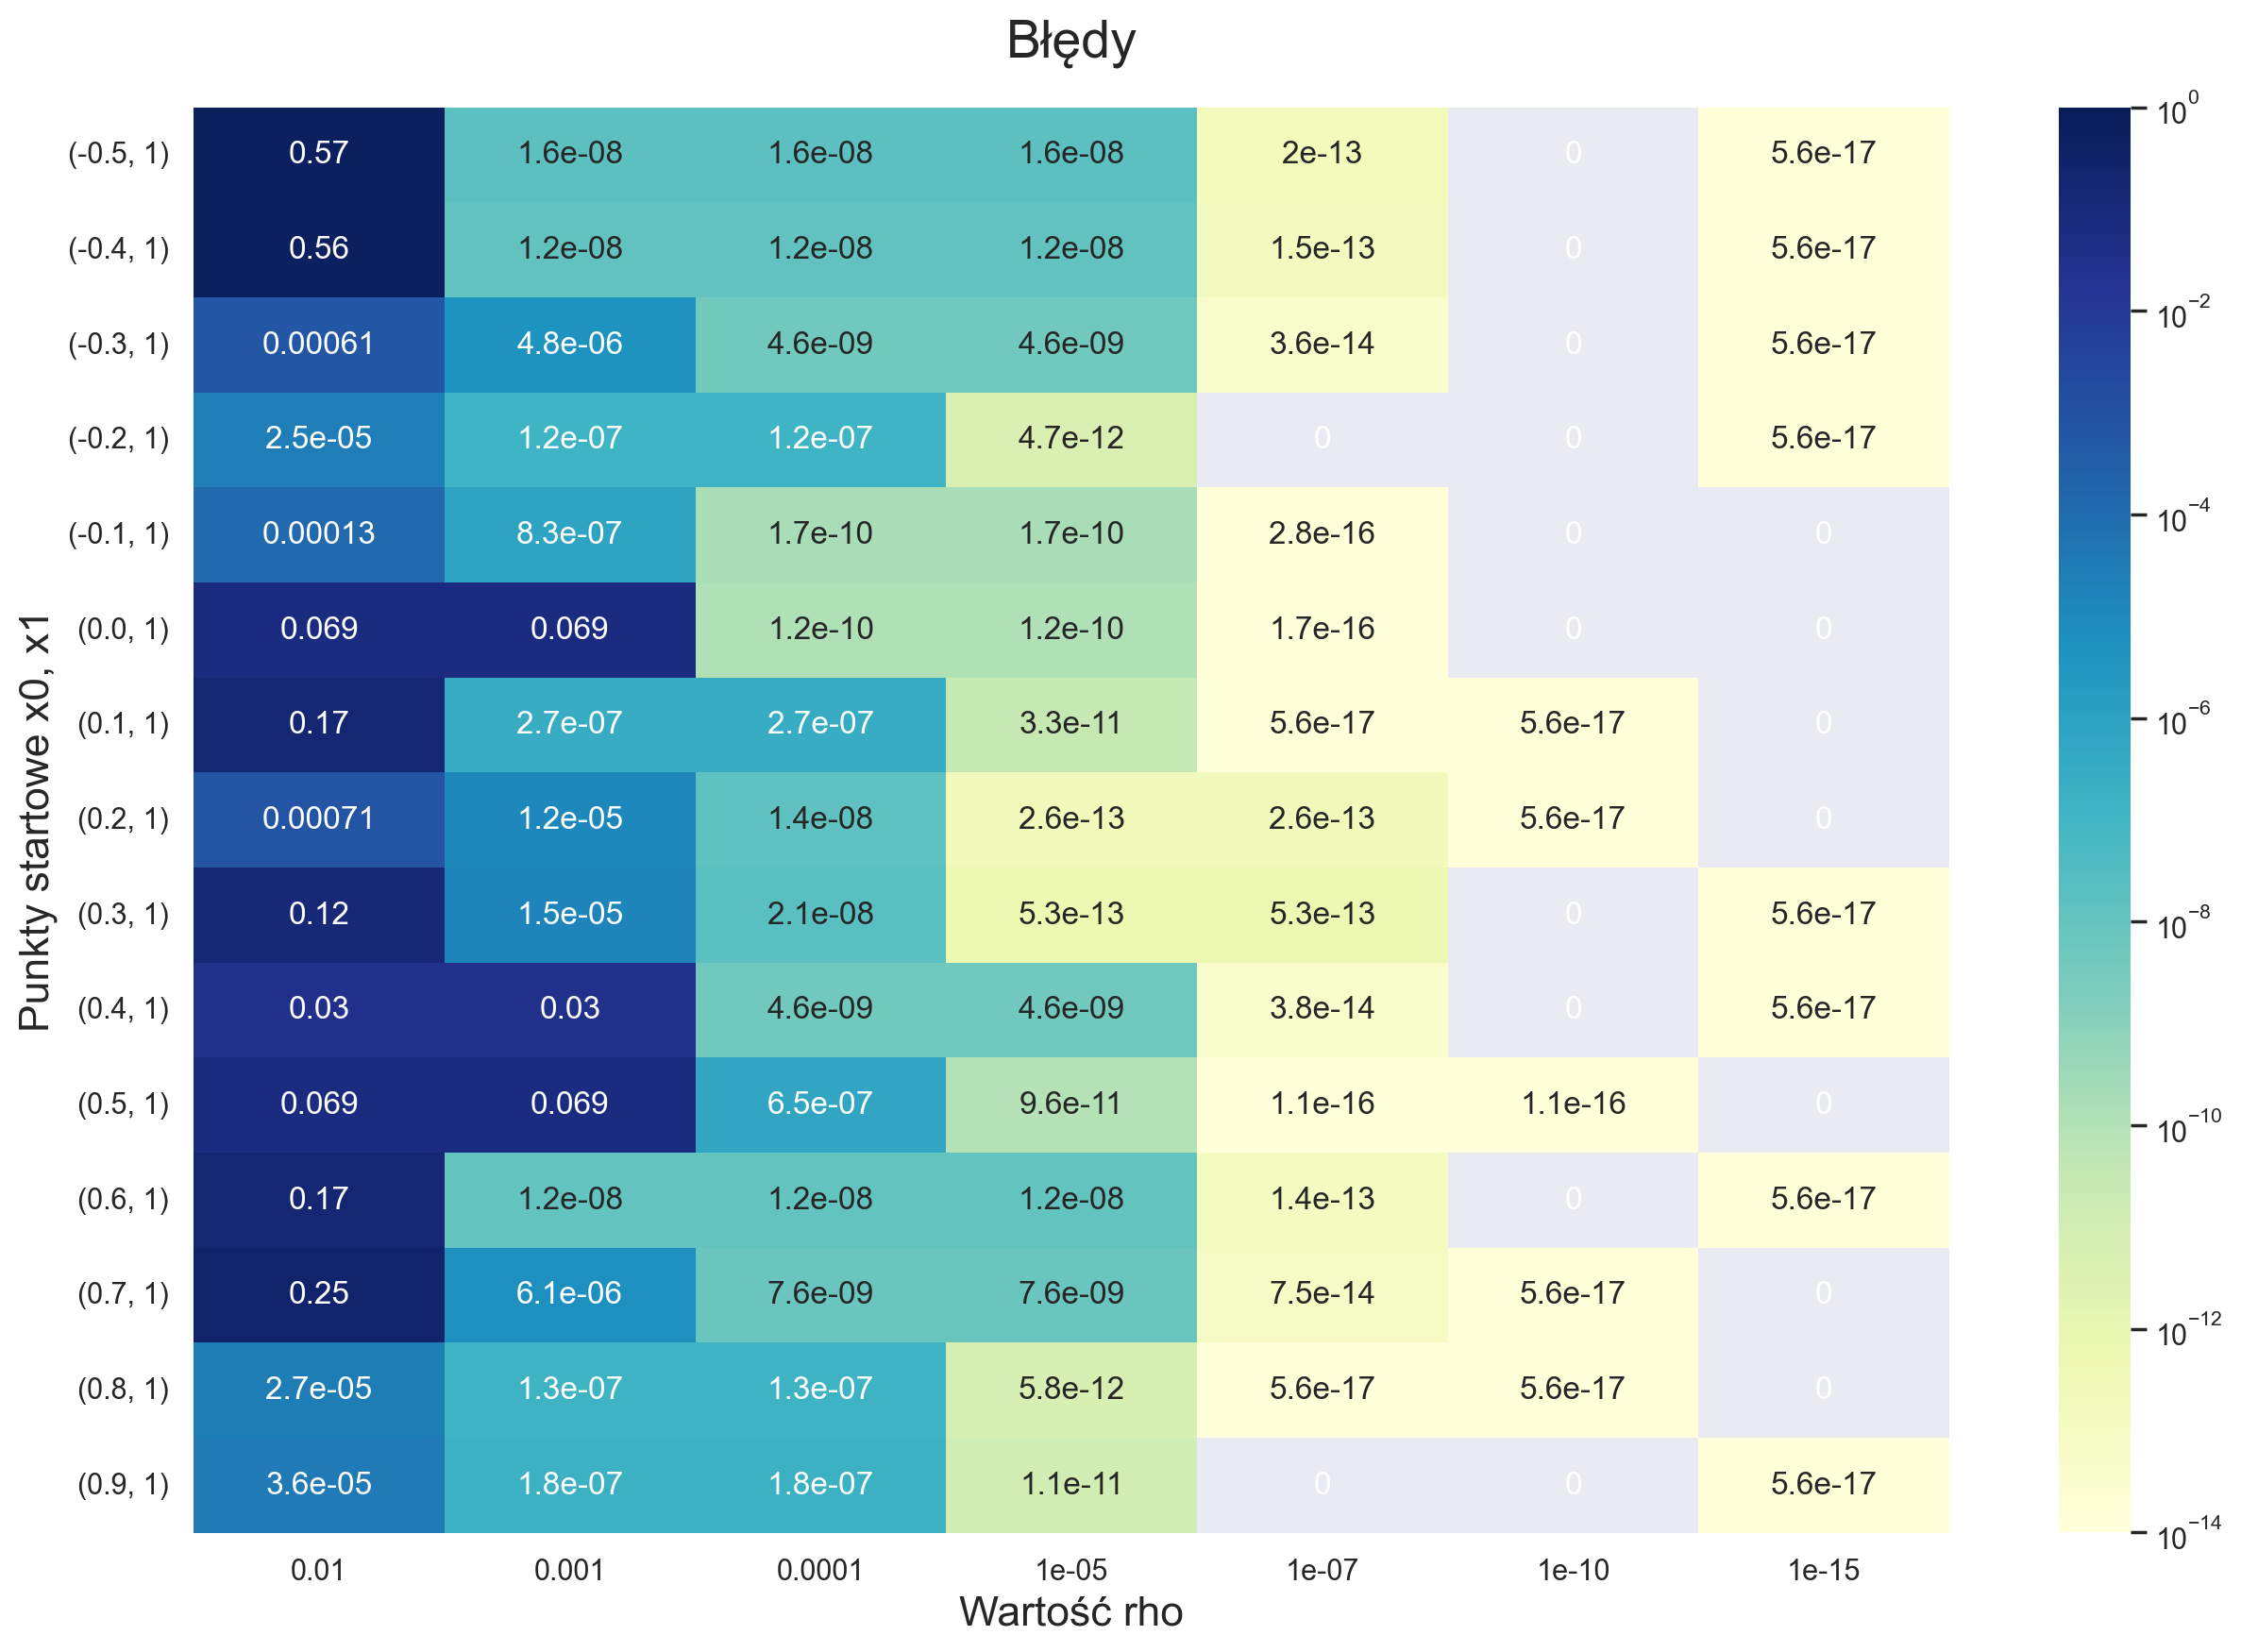

In [483]:
err_df = abs(df1.applymap(lambda cell: cell[0]) - expected_x)
show_heatmap(err_df, xlabel='Wartość rho', ylabel='Punkty startowe x0, x1', title='Błędy', 
             norm=LogNorm(vmin=10e-15, vmax=10e-1))

##### Rezultaty dla kryterium 2.

###### Dla ustalonej wartości początku przedziału

In [510]:
df2 = calculate(a, b, a, stop_criterion_init2, [
    1e-2, 1e-3, 1e-4, 1e-5, 1e-7, 1e-10, 1e-15
])

###### Wyniki

In [511]:
df2.applymap(lambda cell: cell[0])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
"(-0.5, -0.4)",0.267755,0.393200,0.427556,0.430050,0.430159,0.43016,0.43016
"(-0.5, -0.3)",0.267074,0.392693,0.427437,0.430041,0.430159,0.43016,0.43016
"(-0.5, -0.2)",0.278183,0.373942,0.428949,0.430131,0.430160,0.43016,0.43016
"(-0.5, -0.1)",0.265504,0.391525,0.427147,0.430018,0.430159,0.43016,0.43016
"(-0.5, 0.0)",0.296936,0.389253,0.426531,0.429962,0.430158,0.43016,0.43016
"(-0.5, 0.1)",0.268407,0.393852,0.427706,0.430061,0.430159,0.43016,0.43016
"(-0.5, 0.2)",0.282801,0.379149,0.422878,0.429447,0.430160,0.43016,0.43016
"(-0.5, 0.3)",0.300009,0.371762,0.428857,0.430127,0.430160,0.43016,0.43016
"(-0.5, 0.4)",0.400001,0.400001,0.425413,0.429586,0.430154,0.43016,0.43016
"(-0.5, 0.5)",0.499998,0.499998,0.436683,0.430268,0.430159,0.43016,0.43016


###### Liczby iteracji

In [512]:
df2.applymap(lambda cell: cell[1])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
"(-0.5, -0.4)",14,18,20,21,22,23,24
"(-0.5, -0.3)",13,17,19,20,21,22,23
"(-0.5, -0.2)",12,15,18,19,20,21,22
"(-0.5, -0.1)",10,14,16,17,18,19,20
"(-0.5, 0.0)",9,12,14,15,16,17,18
"(-0.5, 0.1)",6,10,12,13,14,15,16
"(-0.5, 0.2)",4,7,9,10,12,13,14
"(-0.5, 0.3)",1,4,7,8,9,10,11
"(-0.5, 0.4)",1,1,3,4,5,6,7
"(-0.5, 0.5)",1,1,4,5,6,7,8


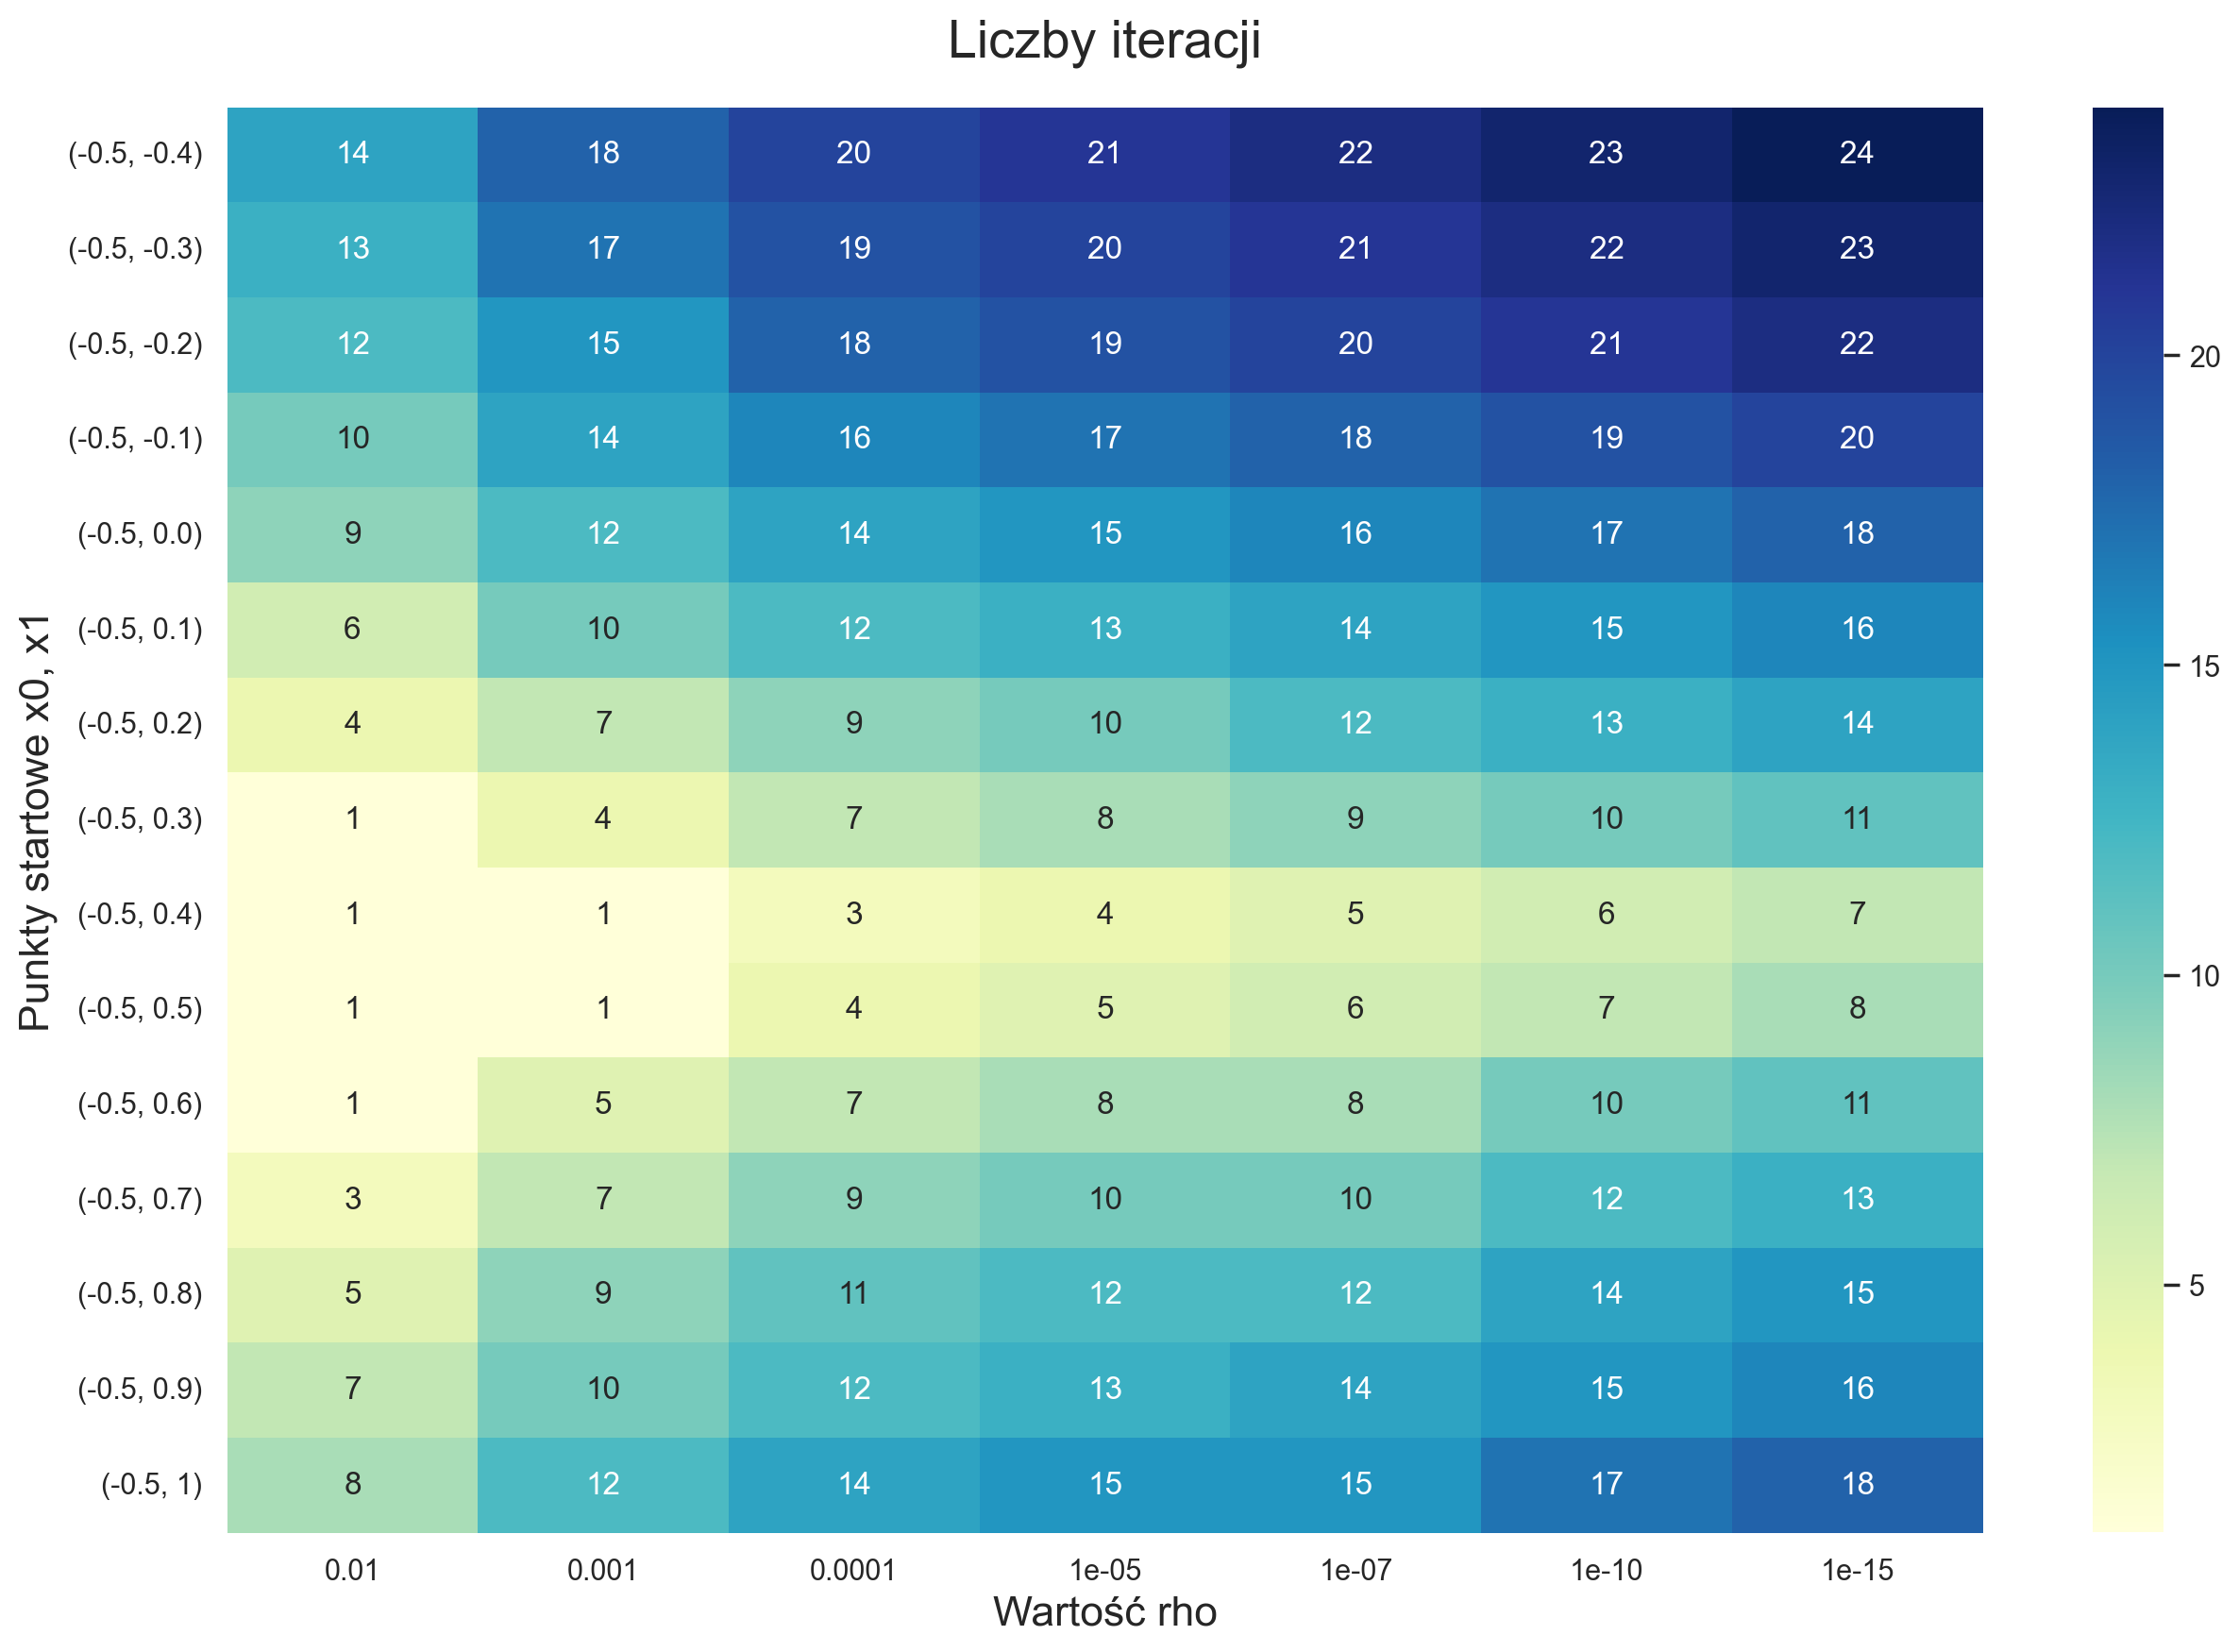

In [513]:
show_heatmap(df2.applymap(lambda cell: cell[1]), 
             xlabel='Wartość rho', ylabel='Punkty startowe x0, x1', title='Liczby iteracji')

##### Błędy

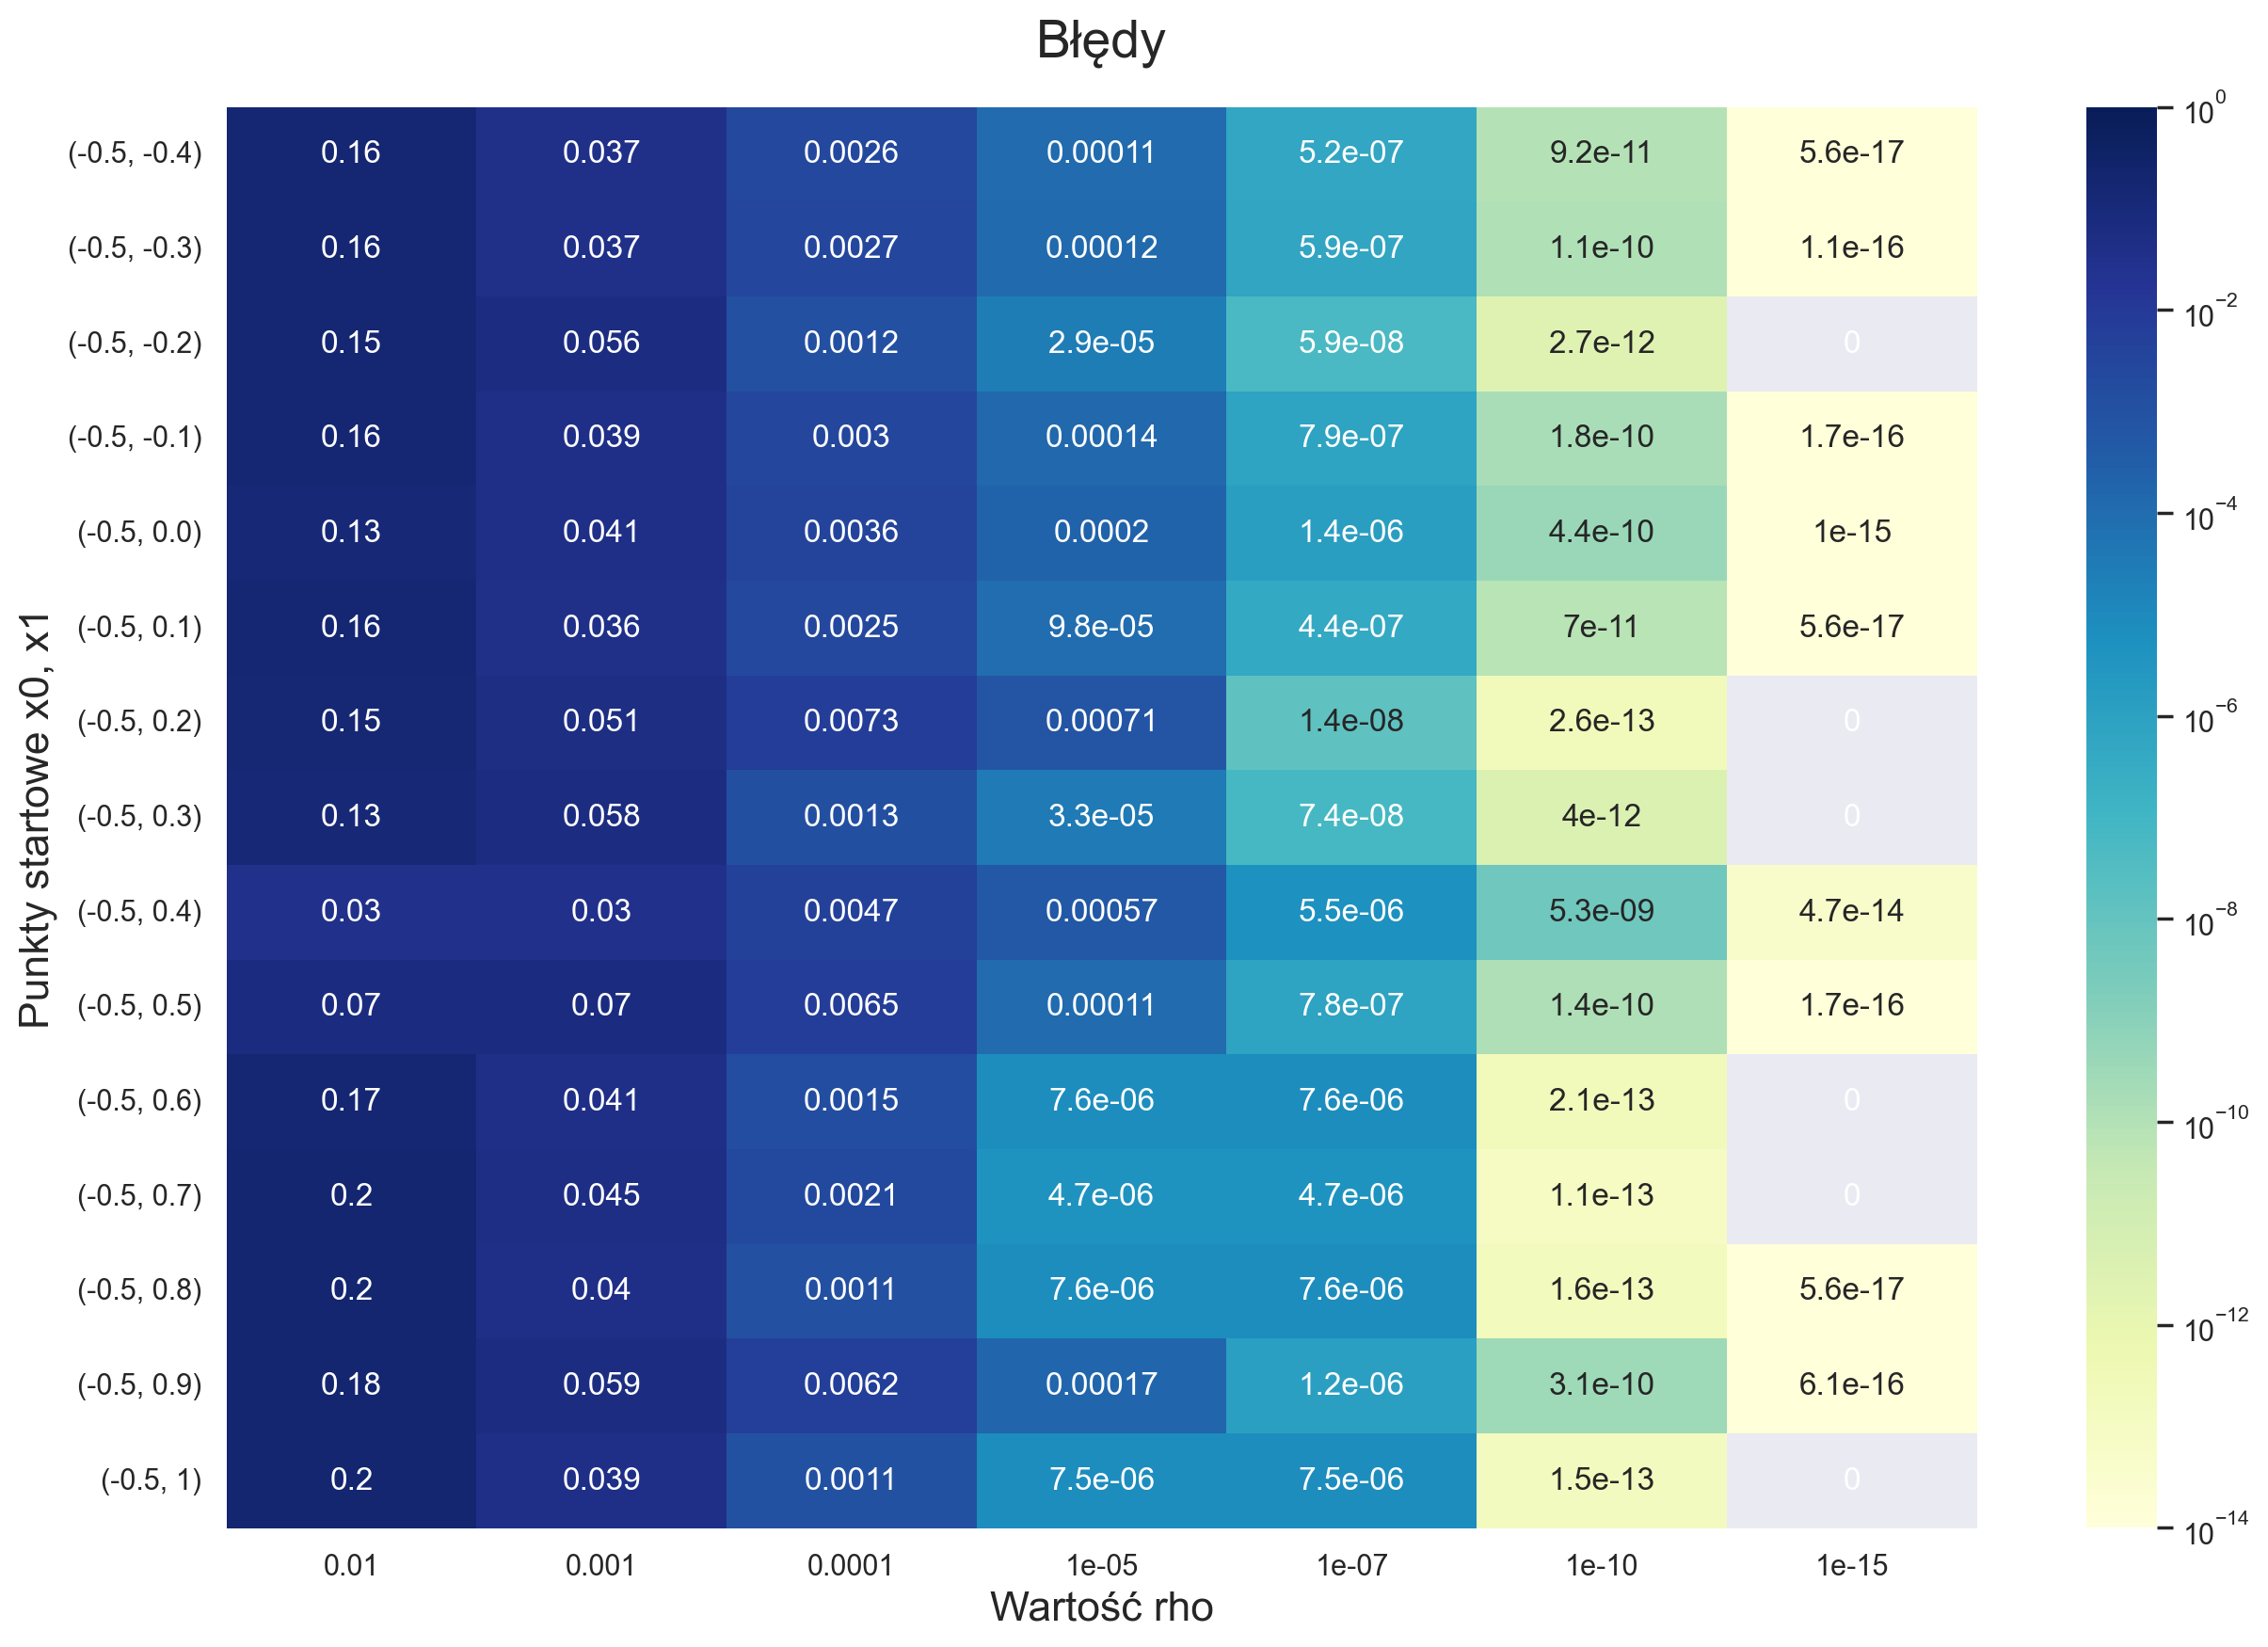

In [514]:
err_df = abs(df2.applymap(lambda cell: cell[0]) - expected_x)
show_heatmap(err_df, xlabel='Wartość rho', ylabel='Punkty startowe x0, x1', title='Błędy', 
             norm=LogNorm(vmin=10e-15, vmax=10e-1))

###### Dla ustalonej wartości końca przedziału

In [515]:
df2 = calculate(a, b, b, stop_criterion_init2, [
    1e-2, 1e-3, 1e-4, 1e-5, 1e-7, 1e-10, 1e-15
])

###### Wyniki

In [516]:
df2.applymap(lambda cell: cell[0])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
"(-0.5, 1)",0.628621,0.470895,0.431463,0.430152,0.430152,0.43016,0.43016
"(-0.4, 1)",0.626424,0.469391,0.431253,0.430152,0.430152,0.43016,0.43016
"(-0.3, 1)",0.619887,0.498252,0.430768,0.430768,0.430155,0.43016,0.43016
"(-0.2, 1)",0.598492,0.481605,0.433747,0.430184,0.430160,0.43016,0.43016
"(-0.1, 1)",0.606304,0.488023,0.435826,0.430286,0.430159,0.43016,0.43016
"(0.0, 1)",0.500000,0.500000,0.436562,0.430262,0.430159,0.43016,0.43016
"(0.1, 1)",0.307815,0.368298,0.428072,0.430086,0.430159,0.43016,0.43016
"(0.2, 1)",0.286514,0.378951,0.422858,0.429447,0.430160,0.43016,0.43016
"(0.3, 1)",0.303303,0.376387,0.422125,0.429328,0.430160,0.43016,0.43016
"(0.4, 1)",0.400219,0.400219,0.425536,0.429613,0.430155,0.43016,0.43016


###### Liczby iteracji

In [517]:
df2.applymap(lambda cell: cell[1])

,1.000000e-02,1.000000e-03,1.000000e-04,1.000000e-05,1.000000e-07,1.000000e-10,1.000000e-15
"(-0.5, 1)",7,11,13,14,14,16,17
"(-0.4, 1)",7,11,13,14,14,16,17
"(-0.3, 1)",7,10,13,13,14,15,16
"(-0.2, 1)",7,10,12,13,14,15,16
"(-0.1, 1)",5,8,10,11,12,13,14
"(0.0, 1)",1,1,4,5,6,7,8
"(0.1, 1)",3,5,8,9,10,11,12
"(0.2, 1)",3,6,8,9,11,12,13
"(0.3, 1)",1,4,6,7,9,10,11
"(0.4, 1)",1,1,3,4,5,6,7


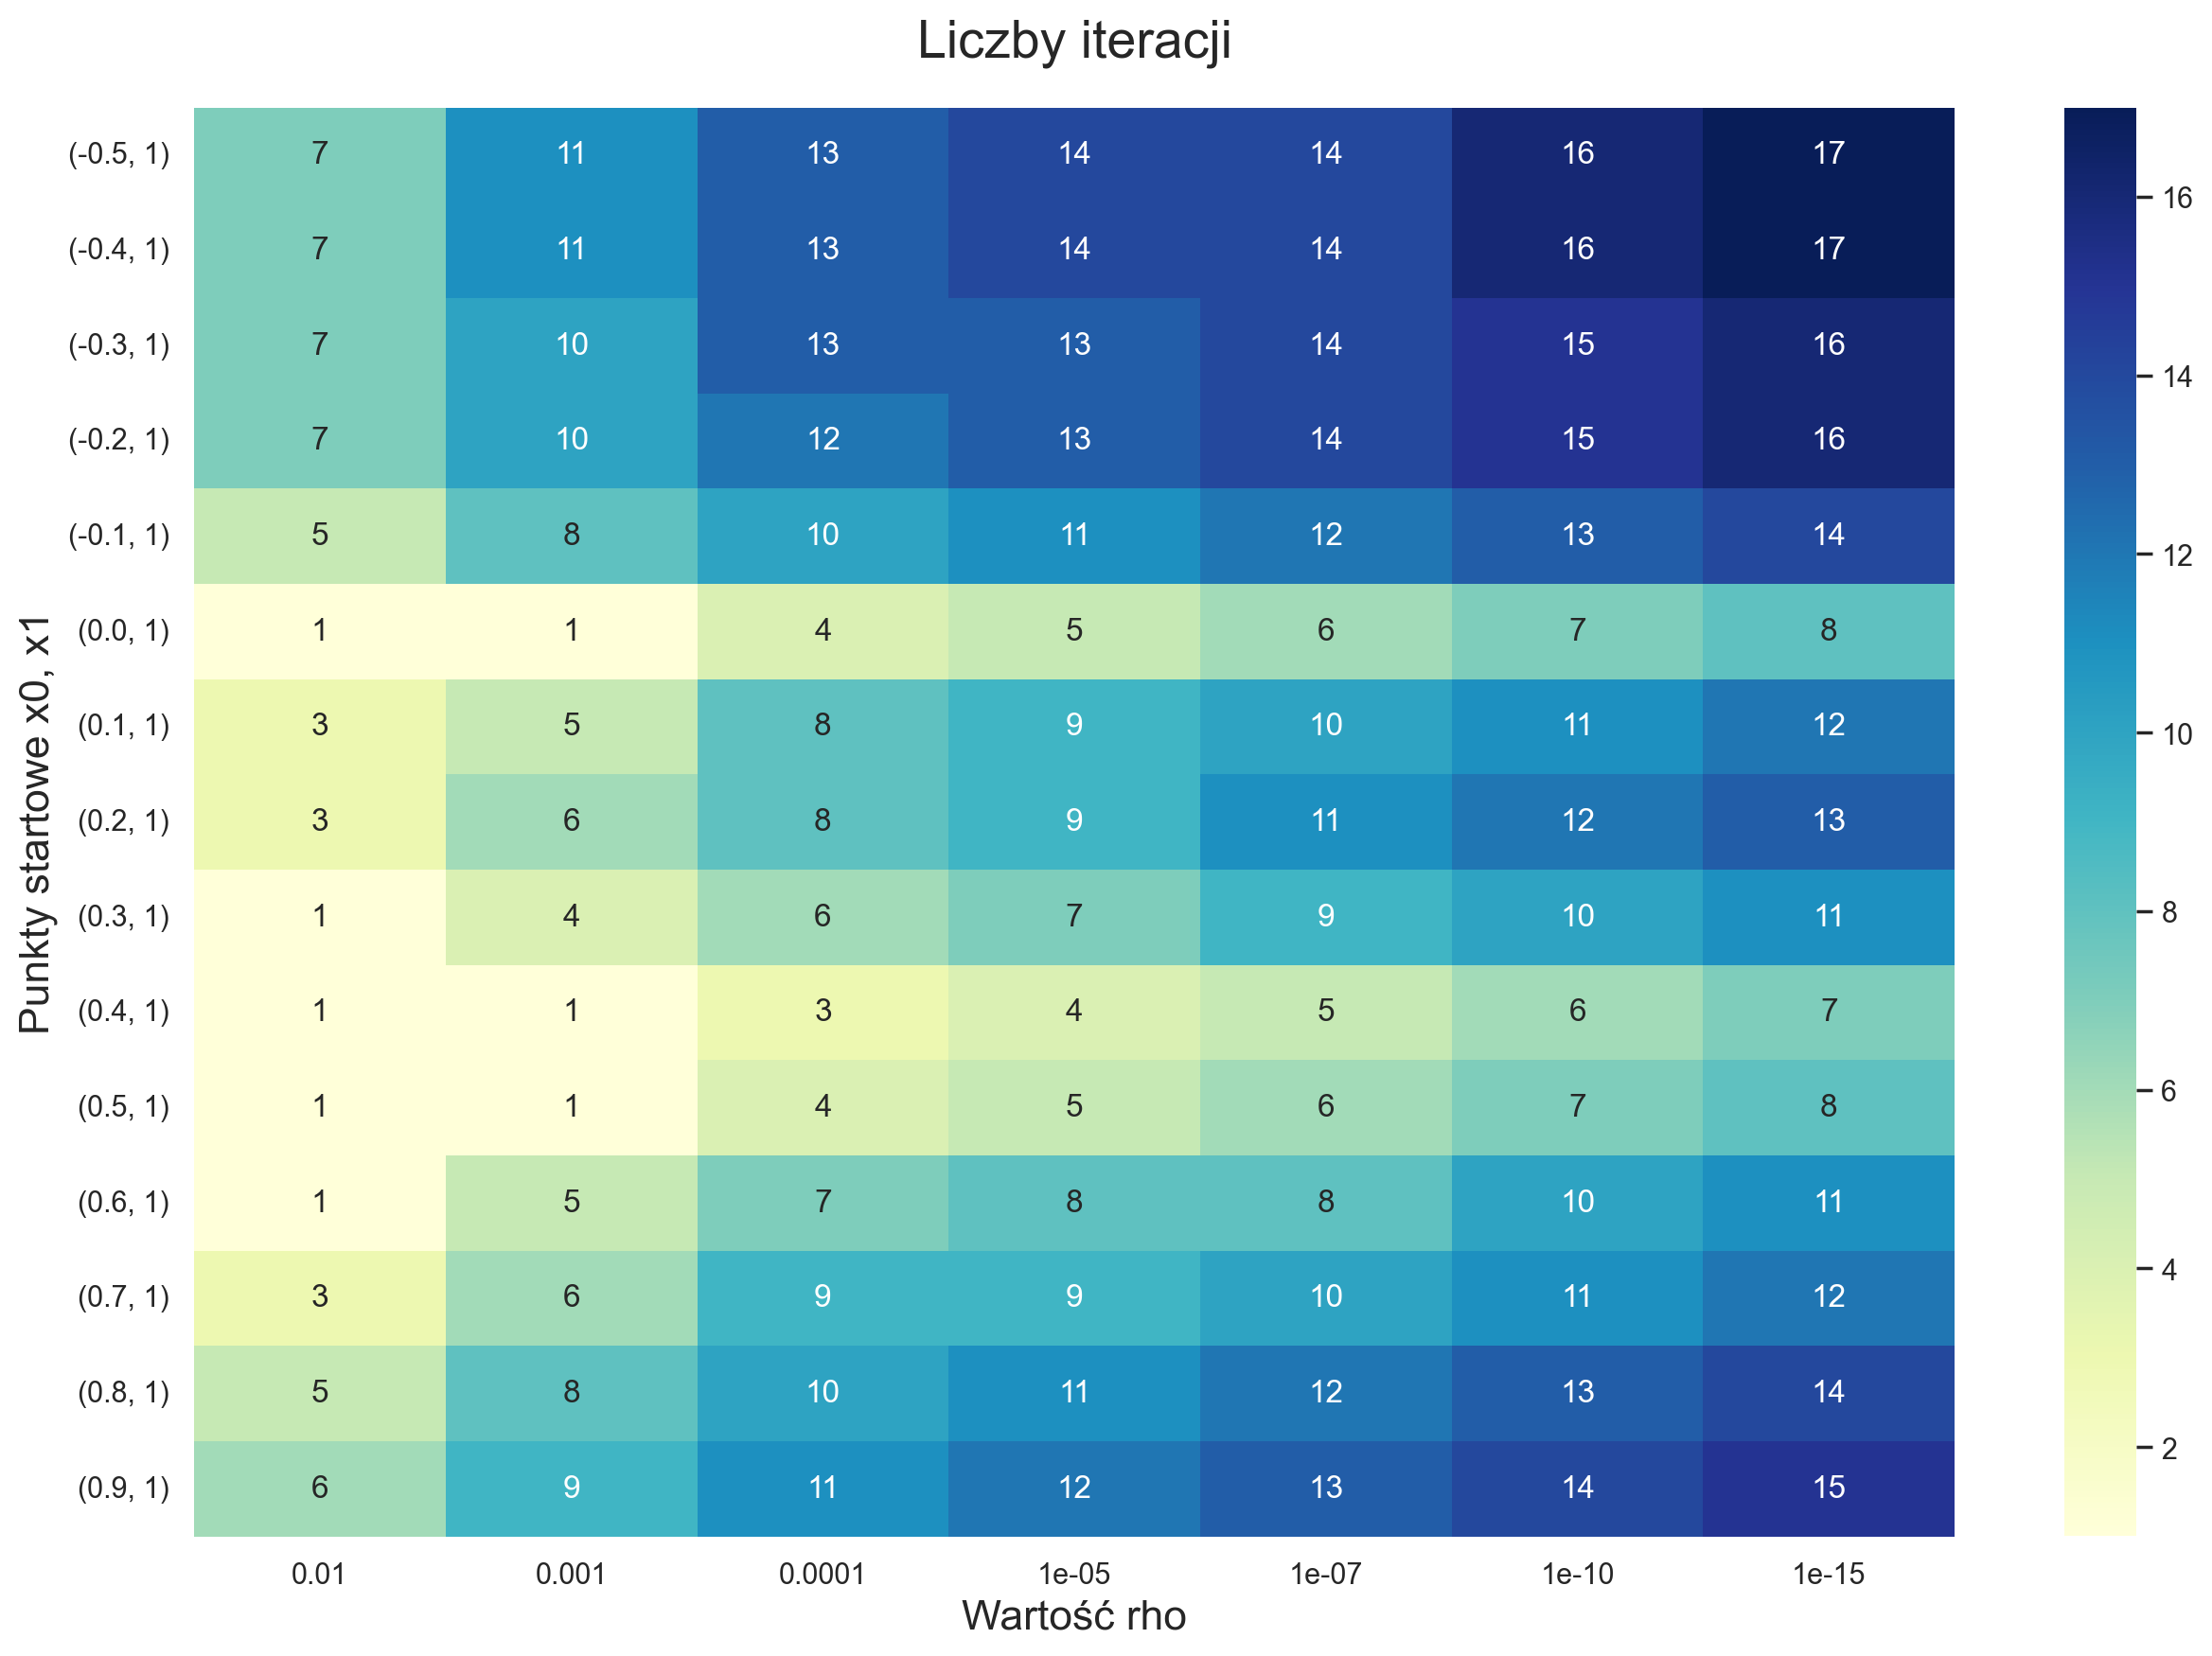

In [518]:
show_heatmap(df2.applymap(lambda cell: cell[1]), 
             xlabel='Wartość rho', ylabel='Punkty startowe x0, x1', title='Liczby iteracji')

###### Błędy

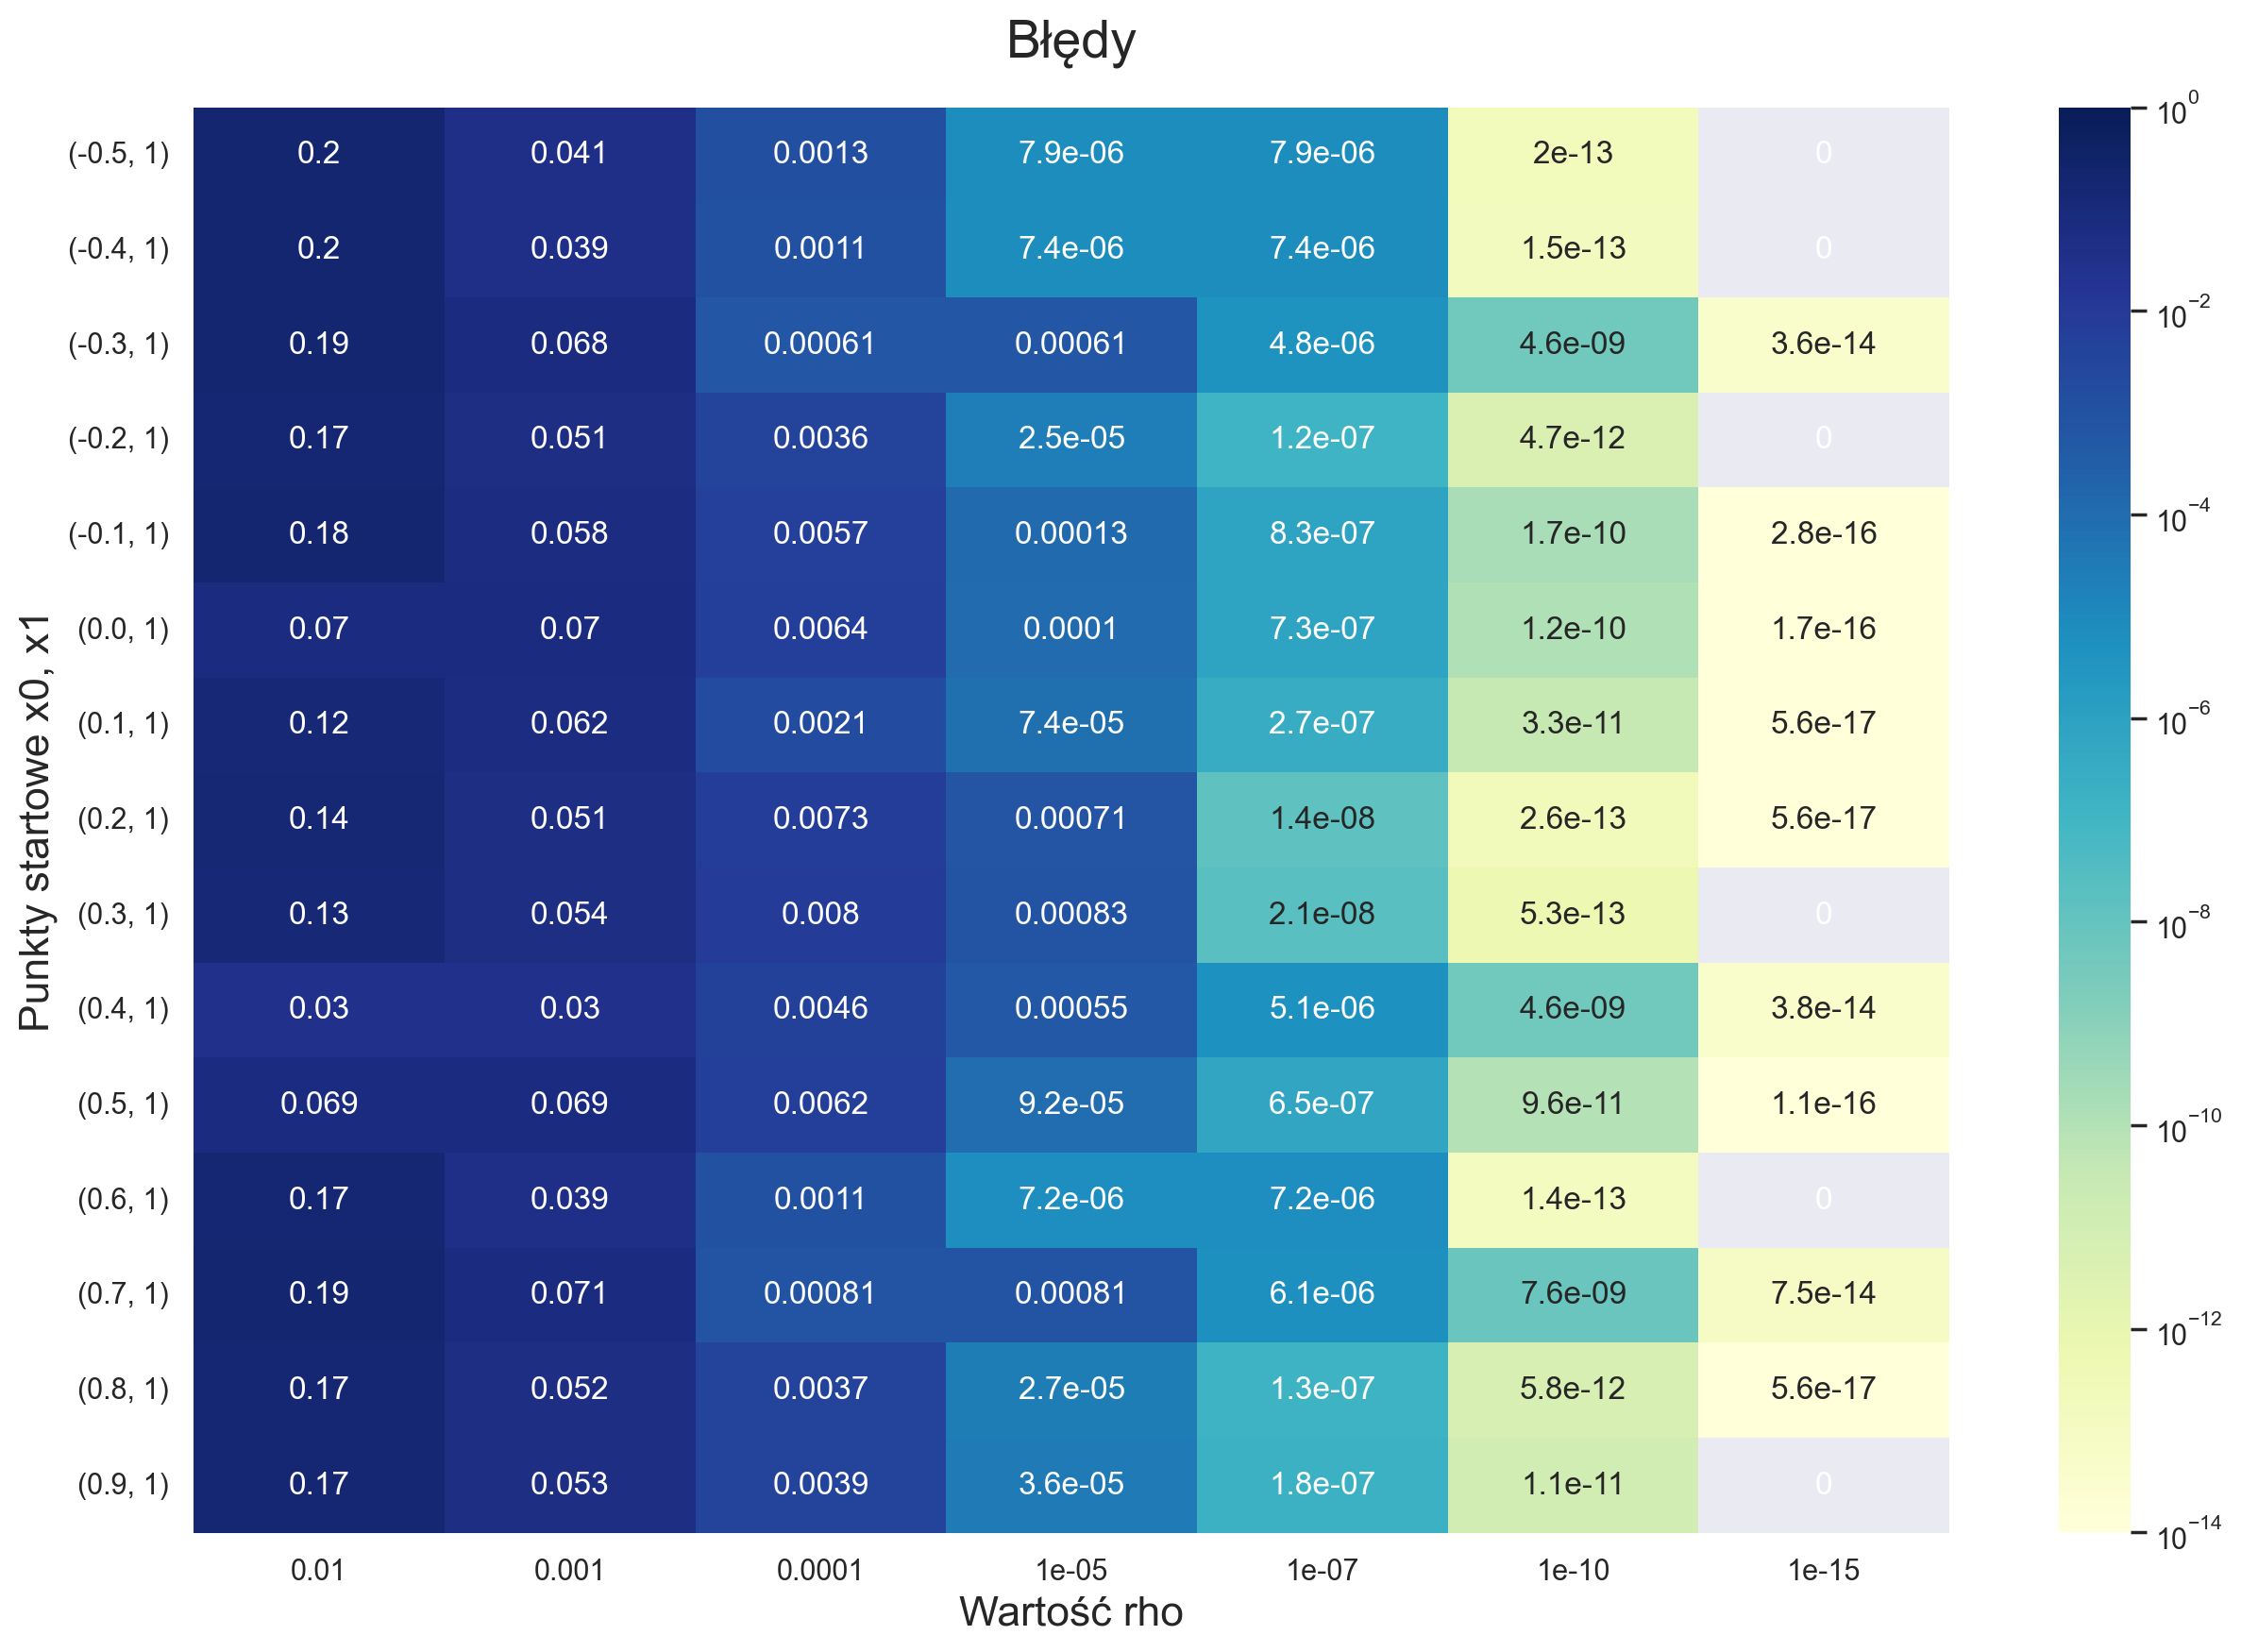

In [519]:
err_df = abs(df2.applymap(lambda cell: cell[0]) - expected_x)
show_heatmap(err_df, xlabel='Wartość rho', ylabel='Punkty startowe x0, x1', title='Błędy', 
             norm=LogNorm(vmin=10e-15, vmax=10e-1))

# Zadanie 2

## Rozwiązywany układ równań

$
\begin{cases} 
    x_1^2-4x_2^2+x_3^3=1 \\ 
    \\
    2x_1^2+4x_2^2-3x_3=0 \\
    \\
    x_1^2-2x_2+x_3^2=1
\end{cases}
$

W postaci macierzowej:

$
F(X) = 
\begin{bmatrix}
    f_1(X) \\
    f_2(X) \\
    f_3(X)
\end{bmatrix}
=
\begin{bmatrix}
    x_1^2-4x_2^2+x_3^3-1 \\ 
    2x_1^2+4x_2^2-3x_3 \\
    x_1^2-2x_2+x_3^2-1
\end{bmatrix}
=
\mathbf{0}
$

## Wyznaczenie liczby iteracji

Do wyznaczenia liczby iteracji, wykorzystam kryteria stopu analogiczne, jak w przypadku rozwiązywania równania nieliniowego.

### Zastosowane kryteria stopu

#### 1. Kryterium

$||X_{(i+i)} - X_{(i)}|| \lt \mathrm{P}$

In [396]:
stop_criterion_init1 = lambda P: lambda _, X_prev, X_curr: (abs(X_curr - X_prev) < P).all()

#### 2. Kryterium

$||F(X_i)|| \lt \mathrm{P}$

In [397]:
stop_criterion_init2 = lambda P: lambda F, _, X_curr: (abs(F(X_curr)) < P).all()

# Metoda Newtona-Raphsona dla układu równań

Najpierw trzeba obliczyć Jakobian macierzy $F(X)$. W przypadku mojego układu równań, ma on postać:

$
J(X) = 
\begin{bmatrix}
    2x_1 & -8x_2 & 3x_3^2 \\
    4x_1 & 8x_2 & -3 \\
    2x_1 & -2 & 2x_3
\end{bmatrix}
$ - jakobian macierzy $F(X)$

Aby uogólnić rozwiązanie na dowolny układ równań, do obliczenia pochodnych cząstkowych wykorzystam bibliotekę sympy.

In [398]:
def find_jacobian(system_of_eq, variables):
    n = len(variables)
    J_repr  = [[None] * n for _ in range(n)]
    J_lambd = [[None] * n for _ in range(n)]
    
    for i, eq in enumerate(system_of_eq):
        for j, xi in enumerate(variables):
            diff = eq.diff(xi)
            J_repr[i][j]  = diff
            J_lambd[i][j] = lambdify(variables, diff)
            
    def J(X):
        n = len(J_lambd)
        m = len(J_lambd[0])
        res = [[0] * m for _ in range(n)]

        for i in range(n):
            for j in range(m):
                res[i][j] = J_lambd[i][j](*X)
        
        return res
            
    return J_repr, J

def lambdify_system_of_eq(system_of_eq, variables):
    F = []
    
    for eq in system_of_eq:
        F.append(lambdify(variables, eq))
        
    return lambda X: np.array([f(*X) for f in F])

In [399]:
x1 = Symbol('x1')
x2 = Symbol('x2')
x3 = Symbol('x3')

system_of_eq = [
    x1**2 - 4*x2**2 + x3**3 - 1,
    2*x1**2 + 4*x2**2 - 3*x3,
    x1**2 - 2*x2 + x3**2 - 1
]

J_repr, J = find_jacobian(system_of_eq, (x1, x2, x3))
print(*J_repr, sep='\n')

[2*x1, -8*x2, 3*x3**2]
[4*x1, 8*x2, -3]
[2*x1, -2, 2*x3]


In [400]:
J([3, 2, 1])

[[6, -16, 3], [12, 16, -3], [6, -2, 2]]

In [401]:
J([1, 1, 1])

[[2, -8, 3], [4, 8, -3], [2, -2, 2]]

In [402]:
F = lambdify_system_of_eq(system_of_eq, (x1, x2, x3))
F([1, 1, 1])

array([-3,  3, -1])

Następnie, wyznaczamy kolejne wektory $X$, korzystając ze wzoru:

$X_{i+1} = X_i - J^{-1}(X_i) \cdot F(X_i)$

$X_i - X_{i+1} = J^{-1}(X_i) \cdot F(X_i)$

Przyjmuję oznaczenie $S = X_i - X_{i+1}$. Otrzymujemy:

$S = J^{-1}(X_i) \cdot F(X_i)$

$J(X_i) \cdot S = F(X_i)$

$S$ obliczymy rozwiązując powyższe równanie. Następnie, $X_{i+1}$ obliczamy ze wzoru:

$X_{i+1} = X_i - S$

Przyjmuję oznaczenia podobne jak w przypadku metody Newtona dla problemu 1-wymiarowego:

$\phi(X) = X - S$

In [403]:
def 𝜙_init(F, J):
    def 𝜙(X):
        S = np.linalg.solve(J(X), F(X))
        return X - S
    
    return 𝜙

### Implementacja

In [ ]:
def newton_raphson_system_of_eq(system_of_eq, variables, X0, stop_criterion, max_iters=1000):
    X_prev = np.full(len(X0), float('inf'))
    X_curr = np.array(X0)
    F = lambdify_system_of_eq(system_of_eq, variables)
    _, J = find_jacobian(system_of_eq, variables)
    𝜙 = 𝜙_init(F, J)
    iters = 0
    
    while not stop_criterion(F, X_prev, X_curr) and iters < max_iters:
        try:
            X_curr, X_prev = 𝜙(X_curr), X_curr
        except np.linalg.LinAlgError:
            X_curr = None
            break
        iters += 1
        
    return X_curr, iters

### Badanie funkcji

#### Przykłady

In [ ]:
X0 = np.array([1, 1, 1])
𝜌 = 1e-5
P = np.array([𝜌] * len(X0))
newton_raphson_system_of_eq(system_of_eq, [x1, x2, x3], X0, stop_criterion_init1(P))

In [ ]:
X0 = np.array([1, 1, 1])
𝜌 = 1e-5
P = np.array([𝜌] * len(X0))
newton_raphson_system_of_eq(system_of_eq, [x1, x2, x3], X0, stop_criterion_init2(P))

#### Wyznaczanie liczby iteracji oraz wyników dla różnych wektorów startowych i różnych kryteriów stopu

##### Dekorator mierzący czas wykonania funkcji

In [ ]:
def print_duration(sec):
    t = int(sec)
    ms = int((sec - t) * 1000)
    s = t % 60
    t //= 60
    m = t % 60
    t //= 60
    print(f'Total execution time: {t:>02}:{m:>02}:{s:>02}.{ms:<03}\n')

def timed(fn):
    def inner(*args, **kwargs):
        start_time = time()
        res = fn(*args, **kwargs)
        print_duration(time() - start_time)
        return res
    return inner

##### Pomocnicze funkcje

In [ ]:
def round_vec(vec, dec_digits):
    return np.vectorize(lambda x: round(x, dec_digits))(vec)

def gen_vectors(A, B, step, dec_digits):
    if len(A) != len(B):
        raise ValueError('A and B vectors must have the same number of dimensions')
    n = len(A)
    
    res = []
    
    def gen(k=0, curr_vec=np.empty(n)):
        if k == n: 
            res.append(round_vec(curr_vec, dec_digits))
            return
        
        m = int(abs(B[k] - A[k]) / step + .5)
        for i in range(m):
            curr_vec[k] = A[k] + i * step
            gen(k + 1, np.copy(curr_vec))
        
        curr_vec[k] = B[k]
        gen(k + 1, np.copy(curr_vec))
    
    gen()
    return res
    
@timed
def calculate(system_of_eq, variables, A, B, stop_criterion_init, P_list, 
              *, step=.1, log_every=1e3, max_iters=10e6, dec_digits=6):
    if len(A) != len(B):
        raise ValueError('A and B vectors must have the same number of dimensions')
    if not all(len(P) == len(A) for P in P_list):
        raise ValueError('All P vectors must have the same number of dimensions as A and B vectors')

    stop_criterions = list(map(stop_criterion_init, P_list))
    X0_list = gen_vectors(A, B, step, dec_digits)
    
    def create_df():
        return pd.DataFrame(
            columns=list(map(tuple, P_list)), 
            index=list(map(tuple, X0_list))
        )

    res_df   = create_df()
    iters_df = create_df()
    
    for i, X0 in enumerate(X0_list):
        if not i % log_every: print(f'Calculated solution for {i}/{len(X0_list)} initial vectors')
            
        for j in range(len(P_list)):
            res_vec, iters = newton_raphson_system_of_eq(system_of_eq, variables, X0, stop_criterions[j], max_iters)
            if res_vec is not None: 
                res_vec = round_vec(res_vec, dec_digits)
            res_df.iloc[i, j]   = res_vec
            iters_df.iloc[i, j] = iters
            
    return res_df, iters_df

##### Rezultaty dla kryterium 1.

In [ ]:
variables = [x1, x2, x3]
A = np.array([-1, -1, -1])
B = np.array([1, 1, 1])
stop_criterion_init = stop_criterion_init1
𝜌_list = [1e-2, 1e-3, 1e-4, 1e-5, 1e-7, 1e-10, 1e-15]
P_list = [np.full(len(A), 𝜌) for 𝜌 in 𝜌_list]

res_df1, iters_df1 = calculate(system_of_eq, variables, A, B, stop_criterion_init, P_list, max_iters=1000, log_every=10)

In [ ]:
res_df1

In [ ]:
iters_df1

##### Rezultaty dla kryterium 2.

In [ ]:
variables = [x1, x2, x3]
A = np.array([-1, -1, -1])
B = np.array([1, 1, 1])
stop_criterion_init = stop_criterion_init2
𝜌_list = [1e-2, 1e-3, 1e-4, 1e-5, 1e-7, 1e-10, 1e-15]
P_list = [np.full(len(A), 𝜌) for 𝜌 in 𝜌_list]

res_df2, iters_df2 = calculate(system_of_eq, variables, A, B, stop_criterion_init, P_list, max_iters=1000, log_every=10)

In [ ]:
res_df2

In [ ]:
iters_df2